In [1]:
%pip install git+https://github.com/KhrulkovV/tt-pytorch.git

  Cloning https://github.com/KhrulkovV/tt-pytorch.git to /tmp/pip-req-build-p40i7hif
  Running command git clone --filter=blob:none --quiet https://github.com/KhrulkovV/tt-pytorch.git /tmp/pip-req-build-p40i7hif
  Resolved https://github.com/KhrulkovV/tt-pytorch.git to commit 3182e8d90fb4c4473b66105159e54486562b6e33
  Preparing metadata (setup.py) ... done
  Created wheel for t3nsor: filename=t3nsor-1.0-py3-none-any.whl size=15565 sha256=42036de986fe502c37955bb1f859d23e382ae0124fcb43670e1af083c4a51eb6
  Stored in directory: /tmp/pip-ephem-wheel-cache-5n407s1c/wheels/b5/15/f2/722c1a04dd0544ebf440585458e01f26f2be83c17660aab367
Successfully built t3nsor
Note: you may need to restart the kernel to use updated packages.


In [2]:
!git clone https://github.com/MaxBourdon/mars.git

Cloning into 'mars'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 31 (delta 9), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (31/31), 432.87 KiB | 4.65 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [3]:
import os

import sys
sys.path.append("/kaggle/working/mars/main")


from tqdm import tqdm

from mars import MARS, get_MARS_attr, set_MARS_attr
from tensorized_models import TTLinear, TTConv2d, TuckerConv2d, FactorizedLinear

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils
import torch.distributions
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cuda'

In [5]:
# Compression modes parameters
modes_dict = {
    "soft": dict(pi=1e-1, alpha=-1.5),
    "hard": dict(pi=1e-2, alpha=-1.75),
}

In [6]:
class FactorizedVariationalEncoder(nn.Module):
    def __init__(self, latent_dims, pi, alpha):
        super(FactorizedVariationalEncoder, self).__init__()
        self.linear1 = MARS(
            FactorizedLinear(784, 512, rank=150),
            pi=pi,
            alpha=alpha
        )
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
class TTVariationalEncoder(nn.Module):
    def __init__(self, latent_dims, pi, alpha):
        super(TTVariationalEncoder, self).__init__()
        self.linear1 = MARS(
            TTLinear(
                784, 
                512, 
                d=6, 
                tt_rank=20, 
                auto_shapes=True
            ),
            pi=pi,
            alpha=alpha
        )
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))
    

class TTDecoder(nn.Module):
    def __init__(self, latent_dims, pi, alpha):
        super(TTDecoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = MARS(
            TTLinear(
                512, 
                784, 
                d=6, 
                tt_rank=20, 
                auto_shapes=True
            ),
            pi=pi,
            alpha=alpha
        )
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))


class FactorizedDecoder(nn.Module):
    def __init__(self, latent_dims, pi, alpha):
        super(FactorizedDecoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = MARS(
            FactorizedLinear(512, 784, rank=200),
            pi=pi,
            alpha=alpha
        )
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [8]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, pi, alpha):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = FactorizedVariationalEncoder(latent_dims, pi, alpha)
#         self.decoder = FactorizedDecoder(latent_dims, pi, alpha)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [9]:
# Modification of MARS class

def compute_cum_reg(model):
    "Compute the cumulative MARS regularizer term of the model."
    reg = 0.0
    
    for layer in model.modules():
        if isinstance(layer, MARS):
            reg += layer.compute_reg()
            
    return reg
    
class MARSLoss(nn.Module):
    def __init__(self, model, train_size, criterion=None, reg_term_coef=1.0):
        """
        MARS regularized loss.

        Parameters are:
        model : MARS
            The tensorized MARS model.
        train_size : int
            The number of training samples.
        criterion : nn.Module
            The criterion calculating log-likelihood.
        reg_term_coef : float
            Regularizer term multiplicative coefficient.
        """
        super().__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss() if criterion is None else criterion
        self.reg_term_coef = reg_term_coef / train_size  # regularization term coefficient
        
    def forward(self, output, target, *args):
        neg_data_term = self.criterion(output, target, *args)
        reg_term = compute_cum_reg(self.model)
        return neg_data_term - self.reg_term_coef * reg_term

In [10]:
def train_mars(model_idx, latent_dims, mode="soft", save=True, load=True):
    """
    Train the model or load the trained one.
    
    Parameters are:
        model_idx : int
            Model index to load or save.
        mode : str in {'soft', 'hard'}
            Compression mode.
        save : bool
            Whether to save the trained model.
        load : bool
            Whether to load the trained model.
    """
    model_directory_path = f"./models/VAE/{mode}/"
    prefix = str(model_idx)
        
    model_path = model_directory_path + prefix + '-model.pt'
    losses_path = model_directory_path + prefix + '-losses.npy'
    print("Model path: ", model_path)

    if save and not os.path.exists(model_directory_path):
        os.makedirs(model_directory_path)
        
    model = VariationalAutoencoder(latent_dims, **modes_dict[mode]).to(device)
    
    if load and os.path.isfile(model_path):
        # load trained model parameters from disk
        model.load_state_dict(torch.load(model_path))
        losses = np.load(losses_path)
        print('Loaded model parameters from disk.')
        return model, losses
    
    model_criterion = lambda x, x_hat, autoencoder: ((x - x_hat)**2).sum() + autoencoder.encoder.kl
    criterion = MARSLoss(model, len(data), model_criterion)
    
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

    print("Training...")
    model.train()
    losses = []
    log_step = len(data) // 300 * 100
    
    for epoch in tqdm(range(n_epochs)):
        running_loss = 0.0
        running_cel = 0.0
        losses.append(0.0)

        for i, (inputs, labels) in enumerate(data, 0):
            # get the inputs
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, inputs, model)
            losses[-1] += loss.item()
            loss.backward()
            optimizer.step()

            # update statistics
            running_loss += loss.item()
            # with torch.no_grad():
            #     cel = cross_entropy(outputs, labels)
            # running_cel += cel.item()

            if i % log_step == log_step-1:
                print('[%d, %5d] \t Loss: %.3f \t T: %.3f' %
                      (epoch + 1, i + 1, 
                       running_loss / log_step, 
                       # running_cel / log_step, 
                       get_MARS_attr(model, "temperature")))
                running_loss = 0.0
                running_cel = 0.0
                
        losses[-1] /= i + 1
        
        new_temp = temp_anneal(get_MARS_attr(model, "temperature"))
        set_MARS_attr(model, "temperature", new_temp)

        scheduler.step()

    losses = np.array(losses)
    print('Finished Training.')
    
    if save:
        torch.save(model.state_dict(), model_path)
        np.save(losses_path, losses)
        print('Saved model parameters to disk.')
    
    return model, losses

In [11]:
latent_dims = 2

n_epochs = 500  
batch_size = 128
lr = 1e-3
gamma = 0.99
temp_anneal = lambda t: max(1e-2, gamma * t)

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=batch_size,
        shuffle=True)

n_models = 1  # set the number of models in ensemble
mode = "hard"  # set the compression mode
models, losses = [], []

100%|██████████| 9912422/9912422 [00:00<00:00, 144773315.66it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 45149345.44it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 42944910.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9172137.11it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [12]:
for k in range(1, n_models + 1):
    print(f"Model number {k}...")
    # model = Autoencoder(latent_dims, **modes_dict[mode])
    
    model, loss = train_mars(k, latent_dims, mode, load=False)
    
    losses.append(loss)
    models.append(model)
    
    print()
    print(100*'=')
    print()

Model number 1...
Model path:  ./models/VAE/hard/1-model.pt
Training...


  0%|          | 0/500 [00:00<?, ?it/s]

[1,   100] 	 Loss: 8026.949 	 T: 0.100
[1,   200] 	 Loss: 6781.006 	 T: 0.100
[1,   300] 	 Loss: 6667.610 	 T: 0.100
[1,   400] 	 Loss: 6485.849 	 T: 0.100


  0%|          | 1/500 [00:09<1:23:03,  9.99s/it]

[2,   100] 	 Loss: 6265.962 	 T: 0.099
[2,   200] 	 Loss: 6145.166 	 T: 0.099
[2,   300] 	 Loss: 6062.429 	 T: 0.099
[2,   400] 	 Loss: 6041.713 	 T: 0.099


  0%|          | 2/500 [00:18<1:13:47,  8.89s/it]

[3,   100] 	 Loss: 5966.856 	 T: 0.098
[3,   200] 	 Loss: 5902.783 	 T: 0.098
[3,   300] 	 Loss: 5873.955 	 T: 0.098
[3,   400] 	 Loss: 5880.319 	 T: 0.098


  1%|          | 3/500 [00:26<1:10:51,  8.55s/it]

[4,   100] 	 Loss: 5811.308 	 T: 0.097
[4,   200] 	 Loss: 5829.745 	 T: 0.097
[4,   300] 	 Loss: 5785.117 	 T: 0.097
[4,   400] 	 Loss: 5773.629 	 T: 0.097


  1%|          | 4/500 [00:34<1:09:43,  8.44s/it]

[5,   100] 	 Loss: 5741.099 	 T: 0.096
[5,   200] 	 Loss: 5762.360 	 T: 0.096
[5,   300] 	 Loss: 5740.084 	 T: 0.096
[5,   400] 	 Loss: 5710.307 	 T: 0.096


  1%|          | 5/500 [00:42<1:08:28,  8.30s/it]

[6,   100] 	 Loss: 5744.908 	 T: 0.095
[6,   200] 	 Loss: 5683.459 	 T: 0.095
[6,   300] 	 Loss: 5711.119 	 T: 0.095
[6,   400] 	 Loss: 5666.620 	 T: 0.095


  1%|          | 6/500 [00:50<1:07:54,  8.25s/it]

[7,   100] 	 Loss: 5685.026 	 T: 0.094
[7,   200] 	 Loss: 5638.836 	 T: 0.094
[7,   300] 	 Loss: 5678.404 	 T: 0.094
[7,   400] 	 Loss: 5656.977 	 T: 0.094


  1%|▏         | 7/500 [00:58<1:07:43,  8.24s/it]

[8,   100] 	 Loss: 5651.416 	 T: 0.093
[8,   200] 	 Loss: 5654.571 	 T: 0.093
[8,   300] 	 Loss: 5615.468 	 T: 0.093
[8,   400] 	 Loss: 5664.715 	 T: 0.093


  2%|▏         | 8/500 [01:07<1:07:29,  8.23s/it]

[9,   100] 	 Loss: 5564.800 	 T: 0.092
[9,   200] 	 Loss: 5599.693 	 T: 0.092
[9,   300] 	 Loss: 5569.985 	 T: 0.092
[9,   400] 	 Loss: 5594.069 	 T: 0.092


  2%|▏         | 9/500 [01:15<1:07:22,  8.23s/it]

[10,   100] 	 Loss: 5573.499 	 T: 0.091
[10,   200] 	 Loss: 5574.266 	 T: 0.091
[10,   300] 	 Loss: 5553.043 	 T: 0.091
[10,   400] 	 Loss: 5550.907 	 T: 0.091


  2%|▏         | 10/500 [01:23<1:07:00,  8.20s/it]

[11,   100] 	 Loss: 5542.083 	 T: 0.090
[11,   200] 	 Loss: 5542.987 	 T: 0.090
[11,   300] 	 Loss: 5526.910 	 T: 0.090
[11,   400] 	 Loss: 5524.733 	 T: 0.090


  2%|▏         | 11/500 [01:31<1:06:46,  8.19s/it]

[12,   100] 	 Loss: 5507.999 	 T: 0.090
[12,   200] 	 Loss: 5516.808 	 T: 0.090
[12,   300] 	 Loss: 5500.016 	 T: 0.090
[12,   400] 	 Loss: 5522.062 	 T: 0.090


  2%|▏         | 12/500 [01:39<1:06:30,  8.18s/it]

[13,   100] 	 Loss: 5472.047 	 T: 0.089
[13,   200] 	 Loss: 5492.353 	 T: 0.089
[13,   300] 	 Loss: 5479.530 	 T: 0.089
[13,   400] 	 Loss: 5485.806 	 T: 0.089


  3%|▎         | 13/500 [01:47<1:06:06,  8.15s/it]

[14,   100] 	 Loss: 5451.744 	 T: 0.088
[14,   200] 	 Loss: 5461.918 	 T: 0.088
[14,   300] 	 Loss: 5457.646 	 T: 0.088
[14,   400] 	 Loss: 5468.527 	 T: 0.088


  3%|▎         | 14/500 [01:55<1:05:45,  8.12s/it]

[15,   100] 	 Loss: 5441.305 	 T: 0.087
[15,   200] 	 Loss: 5419.406 	 T: 0.087
[15,   300] 	 Loss: 5455.878 	 T: 0.087
[15,   400] 	 Loss: 5445.649 	 T: 0.087


  3%|▎         | 15/500 [02:04<1:05:59,  8.16s/it]

[16,   100] 	 Loss: 5420.984 	 T: 0.086
[16,   200] 	 Loss: 5453.221 	 T: 0.086
[16,   300] 	 Loss: 5411.783 	 T: 0.086
[16,   400] 	 Loss: 5378.617 	 T: 0.086


  3%|▎         | 16/500 [02:12<1:05:49,  8.16s/it]

[17,   100] 	 Loss: 5411.393 	 T: 0.085
[17,   200] 	 Loss: 5386.007 	 T: 0.085
[17,   300] 	 Loss: 5384.440 	 T: 0.085
[17,   400] 	 Loss: 5400.127 	 T: 0.085


  3%|▎         | 17/500 [02:20<1:05:29,  8.14s/it]

[18,   100] 	 Loss: 5372.063 	 T: 0.084
[18,   200] 	 Loss: 5389.761 	 T: 0.084
[18,   300] 	 Loss: 5360.640 	 T: 0.084
[18,   400] 	 Loss: 5361.760 	 T: 0.084


  4%|▎         | 18/500 [02:28<1:05:20,  8.13s/it]

[19,   100] 	 Loss: 5363.885 	 T: 0.083
[19,   200] 	 Loss: 5344.265 	 T: 0.083
[19,   300] 	 Loss: 5372.992 	 T: 0.083
[19,   400] 	 Loss: 5360.009 	 T: 0.083


  4%|▍         | 19/500 [02:36<1:05:24,  8.16s/it]

[20,   100] 	 Loss: 5333.562 	 T: 0.083
[20,   200] 	 Loss: 5336.638 	 T: 0.083
[20,   300] 	 Loss: 5305.511 	 T: 0.083
[20,   400] 	 Loss: 5335.045 	 T: 0.083


  4%|▍         | 20/500 [02:44<1:05:02,  8.13s/it]

[21,   100] 	 Loss: 5332.469 	 T: 0.082
[21,   200] 	 Loss: 5326.380 	 T: 0.082
[21,   300] 	 Loss: 5346.581 	 T: 0.082
[21,   400] 	 Loss: 5306.102 	 T: 0.082


  4%|▍         | 21/500 [02:52<1:04:51,  8.12s/it]

[22,   100] 	 Loss: 5342.919 	 T: 0.081
[22,   200] 	 Loss: 5308.835 	 T: 0.081
[22,   300] 	 Loss: 5305.582 	 T: 0.081
[22,   400] 	 Loss: 5295.821 	 T: 0.081


  4%|▍         | 22/500 [03:01<1:04:51,  8.14s/it]

[23,   100] 	 Loss: 5331.205 	 T: 0.080
[23,   200] 	 Loss: 5278.977 	 T: 0.080
[23,   300] 	 Loss: 5284.329 	 T: 0.080
[23,   400] 	 Loss: 5306.201 	 T: 0.080


  5%|▍         | 23/500 [03:09<1:04:45,  8.15s/it]

[24,   100] 	 Loss: 5283.908 	 T: 0.079
[24,   200] 	 Loss: 5259.162 	 T: 0.079
[24,   300] 	 Loss: 5289.771 	 T: 0.079
[24,   400] 	 Loss: 5261.463 	 T: 0.079


  5%|▍         | 24/500 [03:17<1:04:20,  8.11s/it]

[25,   100] 	 Loss: 5256.770 	 T: 0.079
[25,   200] 	 Loss: 5261.105 	 T: 0.079
[25,   300] 	 Loss: 5275.477 	 T: 0.079
[25,   400] 	 Loss: 5252.078 	 T: 0.079


  5%|▌         | 25/500 [03:25<1:04:06,  8.10s/it]

[26,   100] 	 Loss: 5269.014 	 T: 0.078
[26,   200] 	 Loss: 5283.819 	 T: 0.078
[26,   300] 	 Loss: 5262.023 	 T: 0.078
[26,   400] 	 Loss: 5210.567 	 T: 0.078


  5%|▌         | 26/500 [03:33<1:04:13,  8.13s/it]

[27,   100] 	 Loss: 5264.147 	 T: 0.077
[27,   200] 	 Loss: 5213.403 	 T: 0.077
[27,   300] 	 Loss: 5243.226 	 T: 0.077
[27,   400] 	 Loss: 5249.717 	 T: 0.077


  5%|▌         | 27/500 [03:41<1:04:14,  8.15s/it]

[28,   100] 	 Loss: 5239.702 	 T: 0.076
[28,   200] 	 Loss: 5257.878 	 T: 0.076
[28,   300] 	 Loss: 5228.893 	 T: 0.076
[28,   400] 	 Loss: 5211.287 	 T: 0.076


  6%|▌         | 28/500 [03:49<1:03:57,  8.13s/it]

[29,   100] 	 Loss: 5226.238 	 T: 0.075
[29,   200] 	 Loss: 5207.491 	 T: 0.075
[29,   300] 	 Loss: 5204.475 	 T: 0.075
[29,   400] 	 Loss: 5228.764 	 T: 0.075


  6%|▌         | 29/500 [03:58<1:03:52,  8.14s/it]

[30,   100] 	 Loss: 5185.474 	 T: 0.075
[30,   200] 	 Loss: 5197.716 	 T: 0.075
[30,   300] 	 Loss: 5198.301 	 T: 0.075
[30,   400] 	 Loss: 5200.838 	 T: 0.075


  6%|▌         | 30/500 [04:06<1:03:36,  8.12s/it]

[31,   100] 	 Loss: 5208.904 	 T: 0.074
[31,   200] 	 Loss: 5187.769 	 T: 0.074
[31,   300] 	 Loss: 5195.908 	 T: 0.074
[31,   400] 	 Loss: 5157.172 	 T: 0.074


  6%|▌         | 31/500 [04:14<1:03:33,  8.13s/it]

[32,   100] 	 Loss: 5175.915 	 T: 0.073
[32,   200] 	 Loss: 5190.470 	 T: 0.073
[32,   300] 	 Loss: 5173.862 	 T: 0.073
[32,   400] 	 Loss: 5174.435 	 T: 0.073


  6%|▋         | 32/500 [04:22<1:03:20,  8.12s/it]

[33,   100] 	 Loss: 5198.992 	 T: 0.072
[33,   200] 	 Loss: 5167.718 	 T: 0.072
[33,   300] 	 Loss: 5173.946 	 T: 0.072
[33,   400] 	 Loss: 5177.341 	 T: 0.072


  7%|▋         | 33/500 [04:30<1:03:30,  8.16s/it]

[34,   100] 	 Loss: 5198.355 	 T: 0.072
[34,   200] 	 Loss: 5145.945 	 T: 0.072
[34,   300] 	 Loss: 5138.952 	 T: 0.072
[34,   400] 	 Loss: 5161.445 	 T: 0.072


  7%|▋         | 34/500 [04:38<1:03:09,  8.13s/it]

[35,   100] 	 Loss: 5148.284 	 T: 0.071
[35,   200] 	 Loss: 5173.972 	 T: 0.071
[35,   300] 	 Loss: 5148.811 	 T: 0.071
[35,   400] 	 Loss: 5147.717 	 T: 0.071


  7%|▋         | 35/500 [04:46<1:03:04,  8.14s/it]

[36,   100] 	 Loss: 5131.197 	 T: 0.070
[36,   200] 	 Loss: 5168.032 	 T: 0.070
[36,   300] 	 Loss: 5128.172 	 T: 0.070
[36,   400] 	 Loss: 5168.474 	 T: 0.070


  7%|▋         | 36/500 [04:54<1:02:48,  8.12s/it]

[37,   100] 	 Loss: 5136.439 	 T: 0.070
[37,   200] 	 Loss: 5142.345 	 T: 0.070
[37,   300] 	 Loss: 5117.659 	 T: 0.070
[37,   400] 	 Loss: 5120.606 	 T: 0.070


  7%|▋         | 37/500 [05:03<1:02:55,  8.15s/it]

[38,   100] 	 Loss: 5110.066 	 T: 0.069
[38,   200] 	 Loss: 5149.157 	 T: 0.069
[38,   300] 	 Loss: 5099.308 	 T: 0.069
[38,   400] 	 Loss: 5119.433 	 T: 0.069


  8%|▊         | 38/500 [05:11<1:02:51,  8.16s/it]

[39,   100] 	 Loss: 5121.353 	 T: 0.068
[39,   200] 	 Loss: 5099.432 	 T: 0.068
[39,   300] 	 Loss: 5125.699 	 T: 0.068
[39,   400] 	 Loss: 5117.081 	 T: 0.068


  8%|▊         | 39/500 [05:19<1:02:49,  8.18s/it]

[40,   100] 	 Loss: 5115.008 	 T: 0.068
[40,   200] 	 Loss: 5103.660 	 T: 0.068
[40,   300] 	 Loss: 5093.482 	 T: 0.068
[40,   400] 	 Loss: 5096.505 	 T: 0.068


  8%|▊         | 40/500 [05:27<1:02:32,  8.16s/it]

[41,   100] 	 Loss: 5096.258 	 T: 0.067
[41,   200] 	 Loss: 5093.192 	 T: 0.067
[41,   300] 	 Loss: 5071.931 	 T: 0.067
[41,   400] 	 Loss: 5109.846 	 T: 0.067


  8%|▊         | 41/500 [05:35<1:02:27,  8.17s/it]

[42,   100] 	 Loss: 5098.111 	 T: 0.066
[42,   200] 	 Loss: 5120.335 	 T: 0.066
[42,   300] 	 Loss: 5094.744 	 T: 0.066
[42,   400] 	 Loss: 5051.968 	 T: 0.066


  8%|▊         | 42/500 [05:44<1:02:24,  8.18s/it]

[43,   100] 	 Loss: 5088.609 	 T: 0.066
[43,   200] 	 Loss: 5099.833 	 T: 0.066
[43,   300] 	 Loss: 5103.144 	 T: 0.066
[43,   400] 	 Loss: 5089.495 	 T: 0.066


  9%|▊         | 43/500 [05:52<1:02:22,  8.19s/it]

[44,   100] 	 Loss: 5085.283 	 T: 0.065
[44,   200] 	 Loss: 5065.927 	 T: 0.065
[44,   300] 	 Loss: 5070.017 	 T: 0.065
[44,   400] 	 Loss: 5083.894 	 T: 0.065


  9%|▉         | 44/500 [06:00<1:02:12,  8.19s/it]

[45,   100] 	 Loss: 5066.227 	 T: 0.064
[45,   200] 	 Loss: 5073.853 	 T: 0.064
[45,   300] 	 Loss: 5057.091 	 T: 0.064
[45,   400] 	 Loss: 5077.559 	 T: 0.064


  9%|▉         | 45/500 [06:08<1:01:55,  8.17s/it]

[46,   100] 	 Loss: 5067.955 	 T: 0.064
[46,   200] 	 Loss: 5028.738 	 T: 0.064
[46,   300] 	 Loss: 5067.758 	 T: 0.064
[46,   400] 	 Loss: 5087.285 	 T: 0.064


  9%|▉         | 46/500 [06:16<1:01:44,  8.16s/it]

[47,   100] 	 Loss: 5069.475 	 T: 0.063
[47,   200] 	 Loss: 5049.600 	 T: 0.063
[47,   300] 	 Loss: 5064.049 	 T: 0.063
[47,   400] 	 Loss: 5072.129 	 T: 0.063


  9%|▉         | 47/500 [06:24<1:01:39,  8.17s/it]

[48,   100] 	 Loss: 5058.282 	 T: 0.062
[48,   200] 	 Loss: 5036.486 	 T: 0.062
[48,   300] 	 Loss: 5057.715 	 T: 0.062
[48,   400] 	 Loss: 5057.642 	 T: 0.062


 10%|▉         | 48/500 [06:33<1:01:36,  8.18s/it]

[49,   100] 	 Loss: 5031.628 	 T: 0.062
[49,   200] 	 Loss: 5021.741 	 T: 0.062
[49,   300] 	 Loss: 5072.849 	 T: 0.062
[49,   400] 	 Loss: 5033.231 	 T: 0.062


 10%|▉         | 49/500 [06:41<1:01:21,  8.16s/it]

[50,   100] 	 Loss: 5043.612 	 T: 0.061
[50,   200] 	 Loss: 5063.275 	 T: 0.061
[50,   300] 	 Loss: 5036.840 	 T: 0.061
[50,   400] 	 Loss: 5039.784 	 T: 0.061


 10%|█         | 50/500 [06:49<1:01:10,  8.16s/it]

[51,   100] 	 Loss: 5010.053 	 T: 0.061
[51,   200] 	 Loss: 5037.029 	 T: 0.061
[51,   300] 	 Loss: 5039.252 	 T: 0.061
[51,   400] 	 Loss: 5023.026 	 T: 0.061


 10%|█         | 51/500 [06:57<1:00:51,  8.13s/it]

[52,   100] 	 Loss: 5007.866 	 T: 0.060
[52,   200] 	 Loss: 5013.847 	 T: 0.060
[52,   300] 	 Loss: 5044.983 	 T: 0.060
[52,   400] 	 Loss: 5059.627 	 T: 0.060


 10%|█         | 52/500 [07:05<1:00:49,  8.15s/it]

[53,   100] 	 Loss: 5015.636 	 T: 0.059
[53,   200] 	 Loss: 5018.205 	 T: 0.059
[53,   300] 	 Loss: 5003.117 	 T: 0.059
[53,   400] 	 Loss: 5023.041 	 T: 0.059


 11%|█         | 53/500 [07:13<1:00:28,  8.12s/it]

[54,   100] 	 Loss: 5032.478 	 T: 0.059
[54,   200] 	 Loss: 5026.818 	 T: 0.059
[54,   300] 	 Loss: 5005.714 	 T: 0.059
[54,   400] 	 Loss: 5001.434 	 T: 0.059


 11%|█         | 54/500 [07:21<1:00:31,  8.14s/it]

[55,   100] 	 Loss: 5012.889 	 T: 0.058
[55,   200] 	 Loss: 4993.119 	 T: 0.058
[55,   300] 	 Loss: 4999.087 	 T: 0.058
[55,   400] 	 Loss: 5043.585 	 T: 0.058


 11%|█         | 55/500 [07:29<1:00:16,  8.13s/it]

[56,   100] 	 Loss: 5005.061 	 T: 0.058
[56,   200] 	 Loss: 4983.755 	 T: 0.058
[56,   300] 	 Loss: 5018.078 	 T: 0.058
[56,   400] 	 Loss: 4989.874 	 T: 0.058


 11%|█         | 56/500 [07:38<1:00:20,  8.15s/it]

[57,   100] 	 Loss: 5002.028 	 T: 0.057
[57,   200] 	 Loss: 5000.067 	 T: 0.057
[57,   300] 	 Loss: 4970.163 	 T: 0.057
[57,   400] 	 Loss: 5004.110 	 T: 0.057


 11%|█▏        | 57/500 [07:46<1:00:03,  8.13s/it]

[58,   100] 	 Loss: 4970.280 	 T: 0.056
[58,   200] 	 Loss: 4992.717 	 T: 0.056
[58,   300] 	 Loss: 4996.389 	 T: 0.056
[58,   400] 	 Loss: 4977.563 	 T: 0.056


 12%|█▏        | 58/500 [07:54<1:00:05,  8.16s/it]

[59,   100] 	 Loss: 4977.742 	 T: 0.056
[59,   200] 	 Loss: 4960.292 	 T: 0.056
[59,   300] 	 Loss: 4975.533 	 T: 0.056
[59,   400] 	 Loss: 4993.454 	 T: 0.056


 12%|█▏        | 59/500 [08:02<1:00:10,  8.19s/it]

[60,   100] 	 Loss: 4982.646 	 T: 0.055
[60,   200] 	 Loss: 4953.876 	 T: 0.055
[60,   300] 	 Loss: 4987.959 	 T: 0.055
[60,   400] 	 Loss: 4983.913 	 T: 0.055


 12%|█▏        | 60/500 [08:10<59:52,  8.16s/it]  

[61,   100] 	 Loss: 4975.543 	 T: 0.055
[61,   200] 	 Loss: 4989.519 	 T: 0.055
[61,   300] 	 Loss: 4983.378 	 T: 0.055
[61,   400] 	 Loss: 4970.479 	 T: 0.055


 12%|█▏        | 61/500 [08:19<59:49,  8.18s/it]

[62,   100] 	 Loss: 4971.341 	 T: 0.054
[62,   200] 	 Loss: 4973.141 	 T: 0.054
[62,   300] 	 Loss: 4983.364 	 T: 0.054
[62,   400] 	 Loss: 4950.919 	 T: 0.054


 12%|█▏        | 62/500 [08:27<59:34,  8.16s/it]

[63,   100] 	 Loss: 4958.550 	 T: 0.054
[63,   200] 	 Loss: 4967.607 	 T: 0.054
[63,   300] 	 Loss: 4948.588 	 T: 0.054
[63,   400] 	 Loss: 4971.941 	 T: 0.054


 13%|█▎        | 63/500 [08:35<59:38,  8.19s/it]

[64,   100] 	 Loss: 4942.731 	 T: 0.053
[64,   200] 	 Loss: 4966.783 	 T: 0.053
[64,   300] 	 Loss: 4961.365 	 T: 0.053
[64,   400] 	 Loss: 4950.626 	 T: 0.053


 13%|█▎        | 64/500 [08:43<59:16,  8.16s/it]

[65,   100] 	 Loss: 4973.473 	 T: 0.053
[65,   200] 	 Loss: 4956.842 	 T: 0.053
[65,   300] 	 Loss: 4945.605 	 T: 0.053
[65,   400] 	 Loss: 4947.402 	 T: 0.053


 13%|█▎        | 65/500 [08:51<59:05,  8.15s/it]

[66,   100] 	 Loss: 4957.232 	 T: 0.052
[66,   200] 	 Loss: 4945.214 	 T: 0.052
[66,   300] 	 Loss: 4975.411 	 T: 0.052
[66,   400] 	 Loss: 4932.451 	 T: 0.052


 13%|█▎        | 66/500 [08:59<58:46,  8.13s/it]

[67,   100] 	 Loss: 4974.136 	 T: 0.052
[67,   200] 	 Loss: 4942.005 	 T: 0.052
[67,   300] 	 Loss: 4939.592 	 T: 0.052
[67,   400] 	 Loss: 4950.387 	 T: 0.052


 13%|█▎        | 67/500 [09:07<58:45,  8.14s/it]

[68,   100] 	 Loss: 4953.008 	 T: 0.051
[68,   200] 	 Loss: 4940.244 	 T: 0.051
[68,   300] 	 Loss: 4945.566 	 T: 0.051
[68,   400] 	 Loss: 4923.451 	 T: 0.051


 14%|█▎        | 68/500 [09:16<58:38,  8.14s/it]

[69,   100] 	 Loss: 4916.172 	 T: 0.050
[69,   200] 	 Loss: 4927.650 	 T: 0.050
[69,   300] 	 Loss: 4960.993 	 T: 0.050
[69,   400] 	 Loss: 4953.873 	 T: 0.050


 14%|█▍        | 69/500 [09:24<58:44,  8.18s/it]

[70,   100] 	 Loss: 4945.941 	 T: 0.050
[70,   200] 	 Loss: 4938.037 	 T: 0.050
[70,   300] 	 Loss: 4930.234 	 T: 0.050
[70,   400] 	 Loss: 4929.024 	 T: 0.050


 14%|█▍        | 70/500 [09:32<58:30,  8.16s/it]

[71,   100] 	 Loss: 4933.208 	 T: 0.049
[71,   200] 	 Loss: 4926.275 	 T: 0.049
[71,   300] 	 Loss: 4941.287 	 T: 0.049
[71,   400] 	 Loss: 4922.108 	 T: 0.049


 14%|█▍        | 71/500 [09:40<58:27,  8.18s/it]

[72,   100] 	 Loss: 4901.167 	 T: 0.049
[72,   200] 	 Loss: 4932.465 	 T: 0.049
[72,   300] 	 Loss: 4945.144 	 T: 0.049
[72,   400] 	 Loss: 4931.691 	 T: 0.049


 14%|█▍        | 72/500 [09:48<58:07,  8.15s/it]

[73,   100] 	 Loss: 4944.113 	 T: 0.048
[73,   200] 	 Loss: 4925.999 	 T: 0.048
[73,   300] 	 Loss: 4900.581 	 T: 0.048
[73,   400] 	 Loss: 4929.793 	 T: 0.048


 15%|█▍        | 73/500 [09:56<57:58,  8.15s/it]

[74,   100] 	 Loss: 4893.429 	 T: 0.048
[74,   200] 	 Loss: 4914.443 	 T: 0.048
[74,   300] 	 Loss: 4921.820 	 T: 0.048
[74,   400] 	 Loss: 4936.796 	 T: 0.048


 15%|█▍        | 74/500 [10:05<58:00,  8.17s/it]

[75,   100] 	 Loss: 4918.555 	 T: 0.048
[75,   200] 	 Loss: 4893.315 	 T: 0.048
[75,   300] 	 Loss: 4933.125 	 T: 0.048
[75,   400] 	 Loss: 4930.510 	 T: 0.048


 15%|█▌        | 75/500 [10:13<57:48,  8.16s/it]

[76,   100] 	 Loss: 4919.411 	 T: 0.047
[76,   200] 	 Loss: 4910.376 	 T: 0.047
[76,   300] 	 Loss: 4882.694 	 T: 0.047
[76,   400] 	 Loss: 4903.655 	 T: 0.047


 15%|█▌        | 76/500 [10:21<57:37,  8.15s/it]

[77,   100] 	 Loss: 4912.315 	 T: 0.047
[77,   200] 	 Loss: 4895.387 	 T: 0.047
[77,   300] 	 Loss: 4920.484 	 T: 0.047
[77,   400] 	 Loss: 4923.439 	 T: 0.047


 15%|█▌        | 77/500 [10:29<57:37,  8.17s/it]

[78,   100] 	 Loss: 4908.916 	 T: 0.046
[78,   200] 	 Loss: 4932.600 	 T: 0.046
[78,   300] 	 Loss: 4897.959 	 T: 0.046
[78,   400] 	 Loss: 4877.674 	 T: 0.046


 16%|█▌        | 78/500 [10:37<57:27,  8.17s/it]

[79,   100] 	 Loss: 4900.610 	 T: 0.046
[79,   200] 	 Loss: 4897.414 	 T: 0.046
[79,   300] 	 Loss: 4893.111 	 T: 0.046
[79,   400] 	 Loss: 4898.032 	 T: 0.046


 16%|█▌        | 79/500 [10:45<57:18,  8.17s/it]

[80,   100] 	 Loss: 4920.352 	 T: 0.045
[80,   200] 	 Loss: 4894.897 	 T: 0.045
[80,   300] 	 Loss: 4909.304 	 T: 0.045
[80,   400] 	 Loss: 4878.615 	 T: 0.045


 16%|█▌        | 80/500 [10:54<57:17,  8.19s/it]

[81,   100] 	 Loss: 4905.409 	 T: 0.045
[81,   200] 	 Loss: 4875.635 	 T: 0.045
[81,   300] 	 Loss: 4886.877 	 T: 0.045
[81,   400] 	 Loss: 4895.857 	 T: 0.045


 16%|█▌        | 81/500 [11:02<57:18,  8.21s/it]

[82,   100] 	 Loss: 4925.122 	 T: 0.044
[82,   200] 	 Loss: 4887.355 	 T: 0.044
[82,   300] 	 Loss: 4879.354 	 T: 0.044
[82,   400] 	 Loss: 4867.192 	 T: 0.044


 16%|█▋        | 82/500 [11:10<57:13,  8.22s/it]

[83,   100] 	 Loss: 4891.834 	 T: 0.044
[83,   200] 	 Loss: 4863.616 	 T: 0.044
[83,   300] 	 Loss: 4878.677 	 T: 0.044
[83,   400] 	 Loss: 4903.470 	 T: 0.044


 17%|█▋        | 83/500 [11:18<56:50,  8.18s/it]

[84,   100] 	 Loss: 4889.610 	 T: 0.043
[84,   200] 	 Loss: 4884.193 	 T: 0.043
[84,   300] 	 Loss: 4887.726 	 T: 0.043
[84,   400] 	 Loss: 4865.746 	 T: 0.043


 17%|█▋        | 84/500 [11:26<56:47,  8.19s/it]

[85,   100] 	 Loss: 4843.414 	 T: 0.043
[85,   200] 	 Loss: 4888.687 	 T: 0.043
[85,   300] 	 Loss: 4877.443 	 T: 0.043
[85,   400] 	 Loss: 4906.580 	 T: 0.043


 17%|█▋        | 85/500 [11:35<56:40,  8.19s/it]

[86,   100] 	 Loss: 4859.618 	 T: 0.043
[86,   200] 	 Loss: 4879.684 	 T: 0.043
[86,   300] 	 Loss: 4902.811 	 T: 0.043
[86,   400] 	 Loss: 4875.273 	 T: 0.043


 17%|█▋        | 86/500 [11:43<56:24,  8.17s/it]

[87,   100] 	 Loss: 4888.799 	 T: 0.042
[87,   200] 	 Loss: 4858.115 	 T: 0.042
[87,   300] 	 Loss: 4869.265 	 T: 0.042
[87,   400] 	 Loss: 4895.184 	 T: 0.042


 17%|█▋        | 87/500 [11:51<56:03,  8.14s/it]

[88,   100] 	 Loss: 4881.249 	 T: 0.042
[88,   200] 	 Loss: 4841.714 	 T: 0.042
[88,   300] 	 Loss: 4860.332 	 T: 0.042
[88,   400] 	 Loss: 4848.401 	 T: 0.042


 18%|█▊        | 88/500 [11:59<56:08,  8.18s/it]

[89,   100] 	 Loss: 4869.260 	 T: 0.041
[89,   200] 	 Loss: 4876.429 	 T: 0.041
[89,   300] 	 Loss: 4853.503 	 T: 0.041
[89,   400] 	 Loss: 4856.760 	 T: 0.041


 18%|█▊        | 89/500 [12:07<56:10,  8.20s/it]

[90,   100] 	 Loss: 4879.785 	 T: 0.041
[90,   200] 	 Loss: 4839.935 	 T: 0.041
[90,   300] 	 Loss: 4867.710 	 T: 0.041
[90,   400] 	 Loss: 4868.438 	 T: 0.041


 18%|█▊        | 90/500 [12:16<55:54,  8.18s/it]

[91,   100] 	 Loss: 4852.247 	 T: 0.040
[91,   200] 	 Loss: 4858.370 	 T: 0.040
[91,   300] 	 Loss: 4856.767 	 T: 0.040
[91,   400] 	 Loss: 4850.686 	 T: 0.040


 18%|█▊        | 91/500 [12:24<55:37,  8.16s/it]

[92,   100] 	 Loss: 4858.073 	 T: 0.040
[92,   200] 	 Loss: 4880.565 	 T: 0.040
[92,   300] 	 Loss: 4848.788 	 T: 0.040
[92,   400] 	 Loss: 4869.546 	 T: 0.040


 18%|█▊        | 92/500 [12:32<55:34,  8.17s/it]

[93,   100] 	 Loss: 4868.665 	 T: 0.040
[93,   200] 	 Loss: 4862.704 	 T: 0.040
[93,   300] 	 Loss: 4834.275 	 T: 0.040
[93,   400] 	 Loss: 4849.362 	 T: 0.040


 19%|█▊        | 93/500 [12:40<55:26,  8.17s/it]

[94,   100] 	 Loss: 4836.250 	 T: 0.039
[94,   200] 	 Loss: 4882.063 	 T: 0.039
[94,   300] 	 Loss: 4837.355 	 T: 0.039
[94,   400] 	 Loss: 4842.075 	 T: 0.039


 19%|█▉        | 94/500 [12:48<55:06,  8.14s/it]

[95,   100] 	 Loss: 4835.279 	 T: 0.039
[95,   200] 	 Loss: 4864.618 	 T: 0.039
[95,   300] 	 Loss: 4826.163 	 T: 0.039
[95,   400] 	 Loss: 4846.170 	 T: 0.039


 19%|█▉        | 95/500 [12:56<54:50,  8.12s/it]

[96,   100] 	 Loss: 4853.419 	 T: 0.038
[96,   200] 	 Loss: 4834.492 	 T: 0.038
[96,   300] 	 Loss: 4852.856 	 T: 0.038
[96,   400] 	 Loss: 4833.769 	 T: 0.038


 19%|█▉        | 96/500 [13:04<54:51,  8.15s/it]

[97,   100] 	 Loss: 4853.190 	 T: 0.038
[97,   200] 	 Loss: 4800.366 	 T: 0.038
[97,   300] 	 Loss: 4836.091 	 T: 0.038
[97,   400] 	 Loss: 4863.200 	 T: 0.038


 19%|█▉        | 97/500 [13:13<54:54,  8.18s/it]

[98,   100] 	 Loss: 4831.208 	 T: 0.038
[98,   200] 	 Loss: 4841.989 	 T: 0.038
[98,   300] 	 Loss: 4847.845 	 T: 0.038
[98,   400] 	 Loss: 4843.331 	 T: 0.038


 20%|█▉        | 98/500 [13:21<54:56,  8.20s/it]

[99,   100] 	 Loss: 4854.981 	 T: 0.037
[99,   200] 	 Loss: 4818.962 	 T: 0.037
[99,   300] 	 Loss: 4837.248 	 T: 0.037
[99,   400] 	 Loss: 4833.311 	 T: 0.037


 20%|█▉        | 99/500 [13:29<54:57,  8.22s/it]

[100,   100] 	 Loss: 4835.843 	 T: 0.037
[100,   200] 	 Loss: 4843.436 	 T: 0.037
[100,   300] 	 Loss: 4821.023 	 T: 0.037
[100,   400] 	 Loss: 4840.892 	 T: 0.037


 20%|██        | 100/500 [13:37<54:43,  8.21s/it]

[101,   100] 	 Loss: 4831.844 	 T: 0.037
[101,   200] 	 Loss: 4811.498 	 T: 0.037
[101,   300] 	 Loss: 4867.863 	 T: 0.037
[101,   400] 	 Loss: 4830.468 	 T: 0.037


 20%|██        | 101/500 [13:45<54:16,  8.16s/it]

[102,   100] 	 Loss: 4827.630 	 T: 0.036
[102,   200] 	 Loss: 4832.643 	 T: 0.036
[102,   300] 	 Loss: 4828.081 	 T: 0.036
[102,   400] 	 Loss: 4829.043 	 T: 0.036


 20%|██        | 102/500 [13:53<53:56,  8.13s/it]

[103,   100] 	 Loss: 4825.420 	 T: 0.036
[103,   200] 	 Loss: 4828.732 	 T: 0.036
[103,   300] 	 Loss: 4847.037 	 T: 0.036
[103,   400] 	 Loss: 4810.742 	 T: 0.036


 21%|██        | 103/500 [14:02<53:59,  8.16s/it]

[104,   100] 	 Loss: 4826.259 	 T: 0.036
[104,   200] 	 Loss: 4804.764 	 T: 0.036
[104,   300] 	 Loss: 4821.792 	 T: 0.036
[104,   400] 	 Loss: 4839.512 	 T: 0.036


 21%|██        | 104/500 [14:10<53:52,  8.16s/it]

[105,   100] 	 Loss: 4849.262 	 T: 0.035
[105,   200] 	 Loss: 4793.240 	 T: 0.035
[105,   300] 	 Loss: 4822.665 	 T: 0.035
[105,   400] 	 Loss: 4794.312 	 T: 0.035


 21%|██        | 105/500 [14:18<53:38,  8.15s/it]

[106,   100] 	 Loss: 4813.411 	 T: 0.035
[106,   200] 	 Loss: 4811.847 	 T: 0.035
[106,   300] 	 Loss: 4830.143 	 T: 0.035
[106,   400] 	 Loss: 4813.479 	 T: 0.035


 21%|██        | 106/500 [14:26<53:24,  8.13s/it]

[107,   100] 	 Loss: 4832.534 	 T: 0.034
[107,   200] 	 Loss: 4780.545 	 T: 0.034
[107,   300] 	 Loss: 4833.024 	 T: 0.034
[107,   400] 	 Loss: 4819.530 	 T: 0.034


 21%|██▏       | 107/500 [14:34<53:30,  8.17s/it]

[108,   100] 	 Loss: 4824.512 	 T: 0.034
[108,   200] 	 Loss: 4796.692 	 T: 0.034
[108,   300] 	 Loss: 4818.315 	 T: 0.034
[108,   400] 	 Loss: 4805.013 	 T: 0.034


 22%|██▏       | 108/500 [14:42<53:24,  8.18s/it]

[109,   100] 	 Loss: 4811.524 	 T: 0.034
[109,   200] 	 Loss: 4805.114 	 T: 0.034
[109,   300] 	 Loss: 4833.763 	 T: 0.034
[109,   400] 	 Loss: 4796.626 	 T: 0.034


 22%|██▏       | 109/500 [14:51<53:13,  8.17s/it]

[110,   100] 	 Loss: 4815.141 	 T: 0.033
[110,   200] 	 Loss: 4822.390 	 T: 0.033
[110,   300] 	 Loss: 4816.722 	 T: 0.033
[110,   400] 	 Loss: 4796.766 	 T: 0.033


 22%|██▏       | 110/500 [14:59<52:57,  8.15s/it]

[111,   100] 	 Loss: 4804.117 	 T: 0.033
[111,   200] 	 Loss: 4817.045 	 T: 0.033
[111,   300] 	 Loss: 4798.727 	 T: 0.033
[111,   400] 	 Loss: 4817.017 	 T: 0.033


 22%|██▏       | 111/500 [15:07<53:08,  8.20s/it]

[112,   100] 	 Loss: 4829.821 	 T: 0.033
[112,   200] 	 Loss: 4782.162 	 T: 0.033
[112,   300] 	 Loss: 4820.639 	 T: 0.033
[112,   400] 	 Loss: 4799.408 	 T: 0.033


 22%|██▏       | 112/500 [15:15<52:46,  8.16s/it]

[113,   100] 	 Loss: 4806.568 	 T: 0.032
[113,   200] 	 Loss: 4812.333 	 T: 0.032
[113,   300] 	 Loss: 4820.830 	 T: 0.032
[113,   400] 	 Loss: 4801.764 	 T: 0.032


 23%|██▎       | 113/500 [15:23<52:33,  8.15s/it]

[114,   100] 	 Loss: 4778.275 	 T: 0.032
[114,   200] 	 Loss: 4828.229 	 T: 0.032
[114,   300] 	 Loss: 4801.019 	 T: 0.032
[114,   400] 	 Loss: 4787.821 	 T: 0.032


 23%|██▎       | 114/500 [15:31<52:21,  8.14s/it]

[115,   100] 	 Loss: 4792.951 	 T: 0.032
[115,   200] 	 Loss: 4804.324 	 T: 0.032
[115,   300] 	 Loss: 4791.991 	 T: 0.032
[115,   400] 	 Loss: 4801.992 	 T: 0.032


 23%|██▎       | 115/500 [15:40<52:28,  8.18s/it]

[116,   100] 	 Loss: 4767.792 	 T: 0.031
[116,   200] 	 Loss: 4794.027 	 T: 0.031
[116,   300] 	 Loss: 4819.564 	 T: 0.031
[116,   400] 	 Loss: 4810.039 	 T: 0.031


 23%|██▎       | 116/500 [15:48<52:03,  8.13s/it]

[117,   100] 	 Loss: 4802.327 	 T: 0.031
[117,   200] 	 Loss: 4779.632 	 T: 0.031
[117,   300] 	 Loss: 4807.617 	 T: 0.031
[117,   400] 	 Loss: 4784.765 	 T: 0.031


 23%|██▎       | 117/500 [15:56<52:10,  8.17s/it]

[118,   100] 	 Loss: 4783.982 	 T: 0.031
[118,   200] 	 Loss: 4796.563 	 T: 0.031
[118,   300] 	 Loss: 4791.967 	 T: 0.031
[118,   400] 	 Loss: 4805.219 	 T: 0.031


 24%|██▎       | 118/500 [16:04<52:13,  8.20s/it]

[119,   100] 	 Loss: 4801.453 	 T: 0.031
[119,   200] 	 Loss: 4802.790 	 T: 0.031
[119,   300] 	 Loss: 4777.353 	 T: 0.031
[119,   400] 	 Loss: 4786.623 	 T: 0.031


 24%|██▍       | 119/500 [16:12<52:04,  8.20s/it]

[120,   100] 	 Loss: 4814.664 	 T: 0.030
[120,   200] 	 Loss: 4801.941 	 T: 0.030
[120,   300] 	 Loss: 4789.323 	 T: 0.030
[120,   400] 	 Loss: 4792.922 	 T: 0.030


 24%|██▍       | 120/500 [16:21<51:52,  8.19s/it]

[121,   100] 	 Loss: 4809.948 	 T: 0.030
[121,   200] 	 Loss: 4783.711 	 T: 0.030
[121,   300] 	 Loss: 4759.743 	 T: 0.030
[121,   400] 	 Loss: 4777.000 	 T: 0.030


 24%|██▍       | 121/500 [16:29<51:39,  8.18s/it]

[122,   100] 	 Loss: 4777.368 	 T: 0.030
[122,   200] 	 Loss: 4785.079 	 T: 0.030
[122,   300] 	 Loss: 4810.504 	 T: 0.030
[122,   400] 	 Loss: 4771.616 	 T: 0.030


 24%|██▍       | 122/500 [16:37<51:48,  8.22s/it]

[123,   100] 	 Loss: 4782.026 	 T: 0.029
[123,   200] 	 Loss: 4781.513 	 T: 0.029
[123,   300] 	 Loss: 4764.518 	 T: 0.029
[123,   400] 	 Loss: 4784.436 	 T: 0.029


 25%|██▍       | 123/500 [16:45<51:32,  8.20s/it]

[124,   100] 	 Loss: 4798.939 	 T: 0.029
[124,   200] 	 Loss: 4786.540 	 T: 0.029
[124,   300] 	 Loss: 4774.432 	 T: 0.029
[124,   400] 	 Loss: 4761.150 	 T: 0.029


 25%|██▍       | 124/500 [16:53<51:18,  8.19s/it]

[125,   100] 	 Loss: 4788.333 	 T: 0.029
[125,   200] 	 Loss: 4779.037 	 T: 0.029
[125,   300] 	 Loss: 4767.564 	 T: 0.029
[125,   400] 	 Loss: 4798.518 	 T: 0.029


 25%|██▌       | 125/500 [17:01<51:00,  8.16s/it]

[126,   100] 	 Loss: 4779.174 	 T: 0.028
[126,   200] 	 Loss: 4790.703 	 T: 0.028
[126,   300] 	 Loss: 4778.697 	 T: 0.028
[126,   400] 	 Loss: 4771.961 	 T: 0.028


 25%|██▌       | 126/500 [17:10<51:05,  8.20s/it]

[127,   100] 	 Loss: 4779.708 	 T: 0.028
[127,   200] 	 Loss: 4802.270 	 T: 0.028
[127,   300] 	 Loss: 4760.720 	 T: 0.028
[127,   400] 	 Loss: 4774.228 	 T: 0.028


 25%|██▌       | 127/500 [17:18<50:50,  8.18s/it]

[128,   100] 	 Loss: 4777.847 	 T: 0.028
[128,   200] 	 Loss: 4758.943 	 T: 0.028
[128,   300] 	 Loss: 4794.711 	 T: 0.028
[128,   400] 	 Loss: 4767.283 	 T: 0.028


 26%|██▌       | 128/500 [17:26<50:44,  8.18s/it]

[129,   100] 	 Loss: 4785.126 	 T: 0.028
[129,   200] 	 Loss: 4758.344 	 T: 0.028
[129,   300] 	 Loss: 4773.205 	 T: 0.028
[129,   400] 	 Loss: 4779.409 	 T: 0.028


 26%|██▌       | 129/500 [17:34<50:28,  8.16s/it]

[130,   100] 	 Loss: 4775.842 	 T: 0.027
[130,   200] 	 Loss: 4785.174 	 T: 0.027
[130,   300] 	 Loss: 4779.621 	 T: 0.027
[130,   400] 	 Loss: 4756.696 	 T: 0.027


 26%|██▌       | 130/500 [17:42<50:28,  8.18s/it]

[131,   100] 	 Loss: 4760.211 	 T: 0.027
[131,   200] 	 Loss: 4784.499 	 T: 0.027
[131,   300] 	 Loss: 4788.991 	 T: 0.027
[131,   400] 	 Loss: 4764.968 	 T: 0.027


 26%|██▌       | 131/500 [17:50<50:09,  8.16s/it]

[132,   100] 	 Loss: 4769.117 	 T: 0.027
[132,   200] 	 Loss: 4780.270 	 T: 0.027
[132,   300] 	 Loss: 4733.201 	 T: 0.027
[132,   400] 	 Loss: 4772.978 	 T: 0.027


 26%|██▋       | 132/500 [17:59<49:59,  8.15s/it]

[133,   100] 	 Loss: 4766.278 	 T: 0.027
[133,   200] 	 Loss: 4773.004 	 T: 0.027
[133,   300] 	 Loss: 4769.696 	 T: 0.027
[133,   400] 	 Loss: 4765.740 	 T: 0.027


 27%|██▋       | 133/500 [18:07<49:45,  8.13s/it]

[134,   100] 	 Loss: 4764.578 	 T: 0.026
[134,   200] 	 Loss: 4755.413 	 T: 0.026
[134,   300] 	 Loss: 4753.595 	 T: 0.026
[134,   400] 	 Loss: 4768.043 	 T: 0.026


 27%|██▋       | 134/500 [18:15<49:48,  8.16s/it]

[135,   100] 	 Loss: 4753.159 	 T: 0.026
[135,   200] 	 Loss: 4763.872 	 T: 0.026
[135,   300] 	 Loss: 4763.349 	 T: 0.026
[135,   400] 	 Loss: 4766.091 	 T: 0.026


 27%|██▋       | 135/500 [18:23<49:38,  8.16s/it]

[136,   100] 	 Loss: 4756.943 	 T: 0.026
[136,   200] 	 Loss: 4771.040 	 T: 0.026
[136,   300] 	 Loss: 4770.366 	 T: 0.026
[136,   400] 	 Loss: 4777.873 	 T: 0.026


 27%|██▋       | 136/500 [18:31<49:28,  8.16s/it]

[137,   100] 	 Loss: 4769.756 	 T: 0.025
[137,   200] 	 Loss: 4766.194 	 T: 0.025
[137,   300] 	 Loss: 4749.682 	 T: 0.025
[137,   400] 	 Loss: 4774.485 	 T: 0.025


 27%|██▋       | 137/500 [18:39<49:23,  8.16s/it]

[138,   100] 	 Loss: 4754.613 	 T: 0.025
[138,   200] 	 Loss: 4772.073 	 T: 0.025
[138,   300] 	 Loss: 4770.320 	 T: 0.025
[138,   400] 	 Loss: 4743.410 	 T: 0.025


 28%|██▊       | 138/500 [18:48<49:16,  8.17s/it]

[139,   100] 	 Loss: 4749.022 	 T: 0.025
[139,   200] 	 Loss: 4772.529 	 T: 0.025
[139,   300] 	 Loss: 4751.146 	 T: 0.025
[139,   400] 	 Loss: 4759.062 	 T: 0.025


 28%|██▊       | 139/500 [18:56<49:01,  8.15s/it]

[140,   100] 	 Loss: 4739.093 	 T: 0.025
[140,   200] 	 Loss: 4775.465 	 T: 0.025
[140,   300] 	 Loss: 4767.573 	 T: 0.025
[140,   400] 	 Loss: 4748.777 	 T: 0.025


 28%|██▊       | 140/500 [19:04<48:46,  8.13s/it]

[141,   100] 	 Loss: 4749.407 	 T: 0.024
[141,   200] 	 Loss: 4764.116 	 T: 0.024
[141,   300] 	 Loss: 4746.001 	 T: 0.024
[141,   400] 	 Loss: 4762.216 	 T: 0.024


 28%|██▊       | 141/500 [19:12<48:49,  8.16s/it]

[142,   100] 	 Loss: 4712.950 	 T: 0.024
[142,   200] 	 Loss: 4774.599 	 T: 0.024
[142,   300] 	 Loss: 4758.636 	 T: 0.024
[142,   400] 	 Loss: 4776.435 	 T: 0.024


 28%|██▊       | 142/500 [19:20<48:35,  8.15s/it]

[143,   100] 	 Loss: 4735.179 	 T: 0.024
[143,   200] 	 Loss: 4754.036 	 T: 0.024
[143,   300] 	 Loss: 4759.751 	 T: 0.024
[143,   400] 	 Loss: 4754.908 	 T: 0.024


 29%|██▊       | 143/500 [19:28<48:25,  8.14s/it]

[144,   100] 	 Loss: 4757.056 	 T: 0.024
[144,   200] 	 Loss: 4736.317 	 T: 0.024
[144,   300] 	 Loss: 4747.468 	 T: 0.024
[144,   400] 	 Loss: 4741.087 	 T: 0.024


 29%|██▉       | 144/500 [19:36<48:10,  8.12s/it]

[145,   100] 	 Loss: 4746.095 	 T: 0.024
[145,   200] 	 Loss: 4766.743 	 T: 0.024
[145,   300] 	 Loss: 4742.730 	 T: 0.024
[145,   400] 	 Loss: 4752.837 	 T: 0.024


 29%|██▉       | 145/500 [19:45<48:27,  8.19s/it]

[146,   100] 	 Loss: 4728.060 	 T: 0.023
[146,   200] 	 Loss: 4735.058 	 T: 0.023
[146,   300] 	 Loss: 4741.796 	 T: 0.023
[146,   400] 	 Loss: 4772.082 	 T: 0.023


 29%|██▉       | 146/500 [19:53<48:11,  8.17s/it]

[147,   100] 	 Loss: 4740.819 	 T: 0.023
[147,   200] 	 Loss: 4757.359 	 T: 0.023
[147,   300] 	 Loss: 4747.627 	 T: 0.023
[147,   400] 	 Loss: 4744.326 	 T: 0.023


 29%|██▉       | 147/500 [20:01<48:00,  8.16s/it]

[148,   100] 	 Loss: 4764.552 	 T: 0.023
[148,   200] 	 Loss: 4733.543 	 T: 0.023
[148,   300] 	 Loss: 4721.263 	 T: 0.023
[148,   400] 	 Loss: 4769.658 	 T: 0.023


 30%|██▉       | 148/500 [20:09<47:58,  8.18s/it]

[149,   100] 	 Loss: 4737.681 	 T: 0.023
[149,   200] 	 Loss: 4745.241 	 T: 0.023
[149,   300] 	 Loss: 4760.543 	 T: 0.023
[149,   400] 	 Loss: 4731.043 	 T: 0.023


 30%|██▉       | 149/500 [20:17<48:02,  8.21s/it]

[150,   100] 	 Loss: 4740.945 	 T: 0.022
[150,   200] 	 Loss: 4736.351 	 T: 0.022
[150,   300] 	 Loss: 4754.708 	 T: 0.022
[150,   400] 	 Loss: 4732.126 	 T: 0.022


 30%|███       | 150/500 [20:26<47:42,  8.18s/it]

[151,   100] 	 Loss: 4729.675 	 T: 0.022
[151,   200] 	 Loss: 4752.421 	 T: 0.022
[151,   300] 	 Loss: 4752.185 	 T: 0.022
[151,   400] 	 Loss: 4743.019 	 T: 0.022


 30%|███       | 151/500 [20:34<47:31,  8.17s/it]

[152,   100] 	 Loss: 4717.679 	 T: 0.022
[152,   200] 	 Loss: 4731.646 	 T: 0.022
[152,   300] 	 Loss: 4754.380 	 T: 0.022
[152,   400] 	 Loss: 4746.439 	 T: 0.022


 30%|███       | 152/500 [20:42<47:17,  8.15s/it]

[153,   100] 	 Loss: 4741.457 	 T: 0.022
[153,   200] 	 Loss: 4724.436 	 T: 0.022
[153,   300] 	 Loss: 4753.182 	 T: 0.022
[153,   400] 	 Loss: 4725.512 	 T: 0.022


 31%|███       | 153/500 [20:50<47:44,  8.26s/it]

[154,   100] 	 Loss: 4742.723 	 T: 0.021
[154,   200] 	 Loss: 4753.360 	 T: 0.021
[154,   300] 	 Loss: 4737.170 	 T: 0.021
[154,   400] 	 Loss: 4733.742 	 T: 0.021


 31%|███       | 154/500 [20:58<47:21,  8.21s/it]

[155,   100] 	 Loss: 4738.692 	 T: 0.021
[155,   200] 	 Loss: 4727.308 	 T: 0.021
[155,   300] 	 Loss: 4747.640 	 T: 0.021
[155,   400] 	 Loss: 4741.260 	 T: 0.021


 31%|███       | 155/500 [21:07<47:02,  8.18s/it]

[156,   100] 	 Loss: 4735.228 	 T: 0.021
[156,   200] 	 Loss: 4739.132 	 T: 0.021
[156,   300] 	 Loss: 4728.459 	 T: 0.021
[156,   400] 	 Loss: 4739.590 	 T: 0.021


 31%|███       | 156/500 [21:15<46:56,  8.19s/it]

[157,   100] 	 Loss: 4727.358 	 T: 0.021
[157,   200] 	 Loss: 4743.878 	 T: 0.021
[157,   300] 	 Loss: 4720.614 	 T: 0.021
[157,   400] 	 Loss: 4752.894 	 T: 0.021


 31%|███▏      | 157/500 [21:23<46:53,  8.20s/it]

[158,   100] 	 Loss: 4718.472 	 T: 0.021
[158,   200] 	 Loss: 4725.726 	 T: 0.021
[158,   300] 	 Loss: 4727.600 	 T: 0.021
[158,   400] 	 Loss: 4752.949 	 T: 0.021


 32%|███▏      | 158/500 [21:31<46:42,  8.19s/it]

[159,   100] 	 Loss: 4751.414 	 T: 0.020
[159,   200] 	 Loss: 4735.332 	 T: 0.020
[159,   300] 	 Loss: 4737.879 	 T: 0.020
[159,   400] 	 Loss: 4727.632 	 T: 0.020


 32%|███▏      | 159/500 [21:39<46:28,  8.18s/it]

[160,   100] 	 Loss: 4728.145 	 T: 0.020
[160,   200] 	 Loss: 4710.975 	 T: 0.020
[160,   300] 	 Loss: 4740.884 	 T: 0.020
[160,   400] 	 Loss: 4763.328 	 T: 0.020


 32%|███▏      | 160/500 [21:48<46:31,  8.21s/it]

[161,   100] 	 Loss: 4730.495 	 T: 0.020
[161,   200] 	 Loss: 4726.892 	 T: 0.020
[161,   300] 	 Loss: 4720.382 	 T: 0.020
[161,   400] 	 Loss: 4741.096 	 T: 0.020


 32%|███▏      | 161/500 [21:56<46:19,  8.20s/it]

[162,   100] 	 Loss: 4736.140 	 T: 0.020
[162,   200] 	 Loss: 4745.612 	 T: 0.020
[162,   300] 	 Loss: 4729.336 	 T: 0.020
[162,   400] 	 Loss: 4711.959 	 T: 0.020


 32%|███▏      | 162/500 [22:04<46:09,  8.19s/it]

[163,   100] 	 Loss: 4744.599 	 T: 0.020
[163,   200] 	 Loss: 4708.818 	 T: 0.020
[163,   300] 	 Loss: 4711.315 	 T: 0.020
[163,   400] 	 Loss: 4739.968 	 T: 0.020


 33%|███▎      | 163/500 [22:12<45:57,  8.18s/it]

[164,   100] 	 Loss: 4735.847 	 T: 0.019
[164,   200] 	 Loss: 4735.066 	 T: 0.019
[164,   300] 	 Loss: 4710.753 	 T: 0.019
[164,   400] 	 Loss: 4732.782 	 T: 0.019


 33%|███▎      | 164/500 [22:20<45:58,  8.21s/it]

[165,   100] 	 Loss: 4740.788 	 T: 0.019
[165,   200] 	 Loss: 4721.249 	 T: 0.019
[165,   300] 	 Loss: 4701.630 	 T: 0.019
[165,   400] 	 Loss: 4744.343 	 T: 0.019


 33%|███▎      | 165/500 [22:28<45:41,  8.18s/it]

[166,   100] 	 Loss: 4725.365 	 T: 0.019
[166,   200] 	 Loss: 4712.029 	 T: 0.019
[166,   300] 	 Loss: 4723.168 	 T: 0.019
[166,   400] 	 Loss: 4718.814 	 T: 0.019


 33%|███▎      | 166/500 [22:37<45:23,  8.16s/it]

[167,   100] 	 Loss: 4740.007 	 T: 0.019
[167,   200] 	 Loss: 4711.696 	 T: 0.019
[167,   300] 	 Loss: 4719.023 	 T: 0.019
[167,   400] 	 Loss: 4723.427 	 T: 0.019


 33%|███▎      | 167/500 [22:45<45:19,  8.17s/it]

[168,   100] 	 Loss: 4716.970 	 T: 0.019
[168,   200] 	 Loss: 4722.596 	 T: 0.019
[168,   300] 	 Loss: 4710.603 	 T: 0.019
[168,   400] 	 Loss: 4726.160 	 T: 0.019


 34%|███▎      | 168/500 [22:53<45:16,  8.18s/it]

[169,   100] 	 Loss: 4715.964 	 T: 0.018
[169,   200] 	 Loss: 4709.947 	 T: 0.018
[169,   300] 	 Loss: 4725.117 	 T: 0.018
[169,   400] 	 Loss: 4722.246 	 T: 0.018


 34%|███▍      | 169/500 [23:01<45:00,  8.16s/it]

[170,   100] 	 Loss: 4729.799 	 T: 0.018
[170,   200] 	 Loss: 4733.574 	 T: 0.018
[170,   300] 	 Loss: 4689.317 	 T: 0.018
[170,   400] 	 Loss: 4728.689 	 T: 0.018


 34%|███▍      | 170/500 [23:09<44:54,  8.16s/it]

[171,   100] 	 Loss: 4730.089 	 T: 0.018
[171,   200] 	 Loss: 4728.071 	 T: 0.018
[171,   300] 	 Loss: 4713.808 	 T: 0.018
[171,   400] 	 Loss: 4701.352 	 T: 0.018


 34%|███▍      | 171/500 [23:17<44:50,  8.18s/it]

[172,   100] 	 Loss: 4716.953 	 T: 0.018
[172,   200] 	 Loss: 4716.960 	 T: 0.018
[172,   300] 	 Loss: 4704.091 	 T: 0.018
[172,   400] 	 Loss: 4721.955 	 T: 0.018


 34%|███▍      | 172/500 [23:26<44:41,  8.18s/it]

[173,   100] 	 Loss: 4718.369 	 T: 0.018
[173,   200] 	 Loss: 4713.612 	 T: 0.018
[173,   300] 	 Loss: 4717.946 	 T: 0.018
[173,   400] 	 Loss: 4719.229 	 T: 0.018


 35%|███▍      | 173/500 [23:34<44:25,  8.15s/it]

[174,   100] 	 Loss: 4727.644 	 T: 0.018
[174,   200] 	 Loss: 4729.242 	 T: 0.018
[174,   300] 	 Loss: 4713.604 	 T: 0.018
[174,   400] 	 Loss: 4731.965 	 T: 0.018


 35%|███▍      | 174/500 [23:42<44:10,  8.13s/it]

[175,   100] 	 Loss: 4727.396 	 T: 0.017
[175,   200] 	 Loss: 4720.507 	 T: 0.017
[175,   300] 	 Loss: 4725.836 	 T: 0.017
[175,   400] 	 Loss: 4705.347 	 T: 0.017


 35%|███▌      | 175/500 [23:50<44:12,  8.16s/it]

[176,   100] 	 Loss: 4718.231 	 T: 0.017
[176,   200] 	 Loss: 4714.592 	 T: 0.017
[176,   300] 	 Loss: 4714.920 	 T: 0.017
[176,   400] 	 Loss: 4705.307 	 T: 0.017


 35%|███▌      | 176/500 [23:58<43:59,  8.15s/it]

[177,   100] 	 Loss: 4747.018 	 T: 0.017
[177,   200] 	 Loss: 4698.544 	 T: 0.017
[177,   300] 	 Loss: 4724.238 	 T: 0.017
[177,   400] 	 Loss: 4704.837 	 T: 0.017


 35%|███▌      | 177/500 [24:06<43:51,  8.15s/it]

[178,   100] 	 Loss: 4705.416 	 T: 0.017
[178,   200] 	 Loss: 4717.748 	 T: 0.017
[178,   300] 	 Loss: 4728.303 	 T: 0.017
[178,   400] 	 Loss: 4686.366 	 T: 0.017


 36%|███▌      | 178/500 [24:14<43:44,  8.15s/it]

[179,   100] 	 Loss: 4685.572 	 T: 0.017
[179,   200] 	 Loss: 4729.036 	 T: 0.017
[179,   300] 	 Loss: 4731.400 	 T: 0.017
[179,   400] 	 Loss: 4710.021 	 T: 0.017


 36%|███▌      | 179/500 [24:23<43:56,  8.21s/it]

[180,   100] 	 Loss: 4675.143 	 T: 0.017
[180,   200] 	 Loss: 4730.762 	 T: 0.017
[180,   300] 	 Loss: 4695.117 	 T: 0.017
[180,   400] 	 Loss: 4729.751 	 T: 0.017


 36%|███▌      | 180/500 [24:31<43:37,  8.18s/it]

[181,   100] 	 Loss: 4695.670 	 T: 0.016
[181,   200] 	 Loss: 4716.176 	 T: 0.016
[181,   300] 	 Loss: 4700.994 	 T: 0.016
[181,   400] 	 Loss: 4727.271 	 T: 0.016


 36%|███▌      | 181/500 [24:39<43:21,  8.15s/it]

[182,   100] 	 Loss: 4694.268 	 T: 0.016
[182,   200] 	 Loss: 4718.442 	 T: 0.016
[182,   300] 	 Loss: 4740.270 	 T: 0.016
[182,   400] 	 Loss: 4675.260 	 T: 0.016


 36%|███▋      | 182/500 [24:47<43:07,  8.14s/it]

[183,   100] 	 Loss: 4711.204 	 T: 0.016
[183,   200] 	 Loss: 4706.192 	 T: 0.016
[183,   300] 	 Loss: 4708.354 	 T: 0.016
[183,   400] 	 Loss: 4678.235 	 T: 0.016


 37%|███▋      | 183/500 [24:55<43:09,  8.17s/it]

[184,   100] 	 Loss: 4709.295 	 T: 0.016
[184,   200] 	 Loss: 4699.545 	 T: 0.016
[184,   300] 	 Loss: 4723.909 	 T: 0.016
[184,   400] 	 Loss: 4691.667 	 T: 0.016


 37%|███▋      | 184/500 [25:03<42:56,  8.15s/it]

[185,   100] 	 Loss: 4694.105 	 T: 0.016
[185,   200] 	 Loss: 4706.708 	 T: 0.016
[185,   300] 	 Loss: 4718.382 	 T: 0.016
[185,   400] 	 Loss: 4694.453 	 T: 0.016


 37%|███▋      | 185/500 [25:12<42:47,  8.15s/it]

[186,   100] 	 Loss: 4702.297 	 T: 0.016
[186,   200] 	 Loss: 4700.669 	 T: 0.016
[186,   300] 	 Loss: 4720.401 	 T: 0.016
[186,   400] 	 Loss: 4710.344 	 T: 0.016


 37%|███▋      | 186/500 [25:20<42:43,  8.16s/it]

[187,   100] 	 Loss: 4694.729 	 T: 0.015
[187,   200] 	 Loss: 4708.127 	 T: 0.015
[187,   300] 	 Loss: 4693.932 	 T: 0.015
[187,   400] 	 Loss: 4712.377 	 T: 0.015


 37%|███▋      | 187/500 [25:28<42:49,  8.21s/it]

[188,   100] 	 Loss: 4715.849 	 T: 0.015
[188,   200] 	 Loss: 4684.177 	 T: 0.015
[188,   300] 	 Loss: 4709.599 	 T: 0.015
[188,   400] 	 Loss: 4708.019 	 T: 0.015


 38%|███▊      | 188/500 [25:36<42:30,  8.18s/it]

[189,   100] 	 Loss: 4708.750 	 T: 0.015
[189,   200] 	 Loss: 4698.054 	 T: 0.015
[189,   300] 	 Loss: 4717.166 	 T: 0.015
[189,   400] 	 Loss: 4686.669 	 T: 0.015


 38%|███▊      | 189/500 [25:44<42:14,  8.15s/it]

[190,   100] 	 Loss: 4735.515 	 T: 0.015
[190,   200] 	 Loss: 4712.887 	 T: 0.015
[190,   300] 	 Loss: 4676.972 	 T: 0.015
[190,   400] 	 Loss: 4697.786 	 T: 0.015


 38%|███▊      | 190/500 [25:53<42:14,  8.18s/it]

[191,   100] 	 Loss: 4694.577 	 T: 0.015
[191,   200] 	 Loss: 4711.910 	 T: 0.015
[191,   300] 	 Loss: 4692.477 	 T: 0.015
[191,   400] 	 Loss: 4701.364 	 T: 0.015


 38%|███▊      | 191/500 [26:01<42:13,  8.20s/it]

[192,   100] 	 Loss: 4690.067 	 T: 0.015
[192,   200] 	 Loss: 4713.993 	 T: 0.015
[192,   300] 	 Loss: 4715.025 	 T: 0.015
[192,   400] 	 Loss: 4690.032 	 T: 0.015


 38%|███▊      | 192/500 [26:09<42:14,  8.23s/it]

[193,   100] 	 Loss: 4681.822 	 T: 0.015
[193,   200] 	 Loss: 4699.930 	 T: 0.015
[193,   300] 	 Loss: 4705.671 	 T: 0.015
[193,   400] 	 Loss: 4712.556 	 T: 0.015


 39%|███▊      | 193/500 [26:17<41:59,  8.21s/it]

[194,   100] 	 Loss: 4696.465 	 T: 0.014
[194,   200] 	 Loss: 4686.135 	 T: 0.014
[194,   300] 	 Loss: 4706.648 	 T: 0.014
[194,   400] 	 Loss: 4685.896 	 T: 0.014


 39%|███▉      | 194/500 [26:26<41:58,  8.23s/it]

[195,   100] 	 Loss: 4673.244 	 T: 0.014
[195,   200] 	 Loss: 4706.527 	 T: 0.014
[195,   300] 	 Loss: 4680.068 	 T: 0.014
[195,   400] 	 Loss: 4721.765 	 T: 0.014


 39%|███▉      | 195/500 [26:34<41:49,  8.23s/it]

[196,   100] 	 Loss: 4698.017 	 T: 0.014
[196,   200] 	 Loss: 4702.733 	 T: 0.014
[196,   300] 	 Loss: 4699.767 	 T: 0.014
[196,   400] 	 Loss: 4694.326 	 T: 0.014


 39%|███▉      | 196/500 [26:42<41:36,  8.21s/it]

[197,   100] 	 Loss: 4699.864 	 T: 0.014
[197,   200] 	 Loss: 4684.059 	 T: 0.014
[197,   300] 	 Loss: 4696.119 	 T: 0.014
[197,   400] 	 Loss: 4693.848 	 T: 0.014


 39%|███▉      | 197/500 [26:50<41:26,  8.21s/it]

[198,   100] 	 Loss: 4709.093 	 T: 0.014
[198,   200] 	 Loss: 4689.992 	 T: 0.014
[198,   300] 	 Loss: 4704.043 	 T: 0.014
[198,   400] 	 Loss: 4684.278 	 T: 0.014


 40%|███▉      | 198/500 [26:58<41:17,  8.20s/it]

[199,   100] 	 Loss: 4702.012 	 T: 0.014
[199,   200] 	 Loss: 4689.498 	 T: 0.014
[199,   300] 	 Loss: 4689.346 	 T: 0.014
[199,   400] 	 Loss: 4707.908 	 T: 0.014


 40%|███▉      | 199/500 [27:06<41:02,  8.18s/it]

[200,   100] 	 Loss: 4700.563 	 T: 0.014
[200,   200] 	 Loss: 4686.806 	 T: 0.014
[200,   300] 	 Loss: 4682.881 	 T: 0.014
[200,   400] 	 Loss: 4701.463 	 T: 0.014


 40%|████      | 200/500 [27:15<40:50,  8.17s/it]

[201,   100] 	 Loss: 4663.482 	 T: 0.013
[201,   200] 	 Loss: 4698.555 	 T: 0.013
[201,   300] 	 Loss: 4710.507 	 T: 0.013
[201,   400] 	 Loss: 4689.864 	 T: 0.013


 40%|████      | 201/500 [27:23<40:46,  8.18s/it]

[202,   100] 	 Loss: 4717.106 	 T: 0.013
[202,   200] 	 Loss: 4680.494 	 T: 0.013
[202,   300] 	 Loss: 4700.885 	 T: 0.013
[202,   400] 	 Loss: 4678.115 	 T: 0.013


 40%|████      | 202/500 [27:31<40:39,  8.19s/it]

[203,   100] 	 Loss: 4688.702 	 T: 0.013
[203,   200] 	 Loss: 4701.390 	 T: 0.013
[203,   300] 	 Loss: 4690.801 	 T: 0.013
[203,   400] 	 Loss: 4680.629 	 T: 0.013


 41%|████      | 203/500 [27:39<40:23,  8.16s/it]

[204,   100] 	 Loss: 4682.096 	 T: 0.013
[204,   200] 	 Loss: 4678.523 	 T: 0.013
[204,   300] 	 Loss: 4700.719 	 T: 0.013
[204,   400] 	 Loss: 4685.857 	 T: 0.013


 41%|████      | 204/500 [27:47<40:10,  8.14s/it]

[205,   100] 	 Loss: 4682.071 	 T: 0.013
[205,   200] 	 Loss: 4686.470 	 T: 0.013
[205,   300] 	 Loss: 4707.573 	 T: 0.013
[205,   400] 	 Loss: 4698.485 	 T: 0.013


 41%|████      | 205/500 [27:55<40:04,  8.15s/it]

[206,   100] 	 Loss: 4671.537 	 T: 0.013
[206,   200] 	 Loss: 4705.544 	 T: 0.013
[206,   300] 	 Loss: 4696.115 	 T: 0.013
[206,   400] 	 Loss: 4683.537 	 T: 0.013


 41%|████      | 206/500 [28:04<40:03,  8.17s/it]

[207,   100] 	 Loss: 4694.353 	 T: 0.013
[207,   200] 	 Loss: 4675.706 	 T: 0.013
[207,   300] 	 Loss: 4707.656 	 T: 0.013
[207,   400] 	 Loss: 4700.437 	 T: 0.013


 41%|████▏     | 207/500 [28:12<39:59,  8.19s/it]

[208,   100] 	 Loss: 4677.806 	 T: 0.012
[208,   200] 	 Loss: 4706.083 	 T: 0.012
[208,   300] 	 Loss: 4699.814 	 T: 0.012
[208,   400] 	 Loss: 4688.777 	 T: 0.012


 42%|████▏     | 208/500 [28:20<39:50,  8.19s/it]

[209,   100] 	 Loss: 4707.462 	 T: 0.012
[209,   200] 	 Loss: 4674.854 	 T: 0.012
[209,   300] 	 Loss: 4700.114 	 T: 0.012
[209,   400] 	 Loss: 4685.125 	 T: 0.012


 42%|████▏     | 209/500 [28:28<39:41,  8.18s/it]

[210,   100] 	 Loss: 4699.467 	 T: 0.012
[210,   200] 	 Loss: 4696.048 	 T: 0.012
[210,   300] 	 Loss: 4682.761 	 T: 0.012
[210,   400] 	 Loss: 4677.609 	 T: 0.012


 42%|████▏     | 210/500 [28:36<39:41,  8.21s/it]

[211,   100] 	 Loss: 4720.165 	 T: 0.012
[211,   200] 	 Loss: 4681.887 	 T: 0.012
[211,   300] 	 Loss: 4670.320 	 T: 0.012
[211,   400] 	 Loss: 4677.357 	 T: 0.012


 42%|████▏     | 211/500 [28:45<39:22,  8.18s/it]

[212,   100] 	 Loss: 4690.324 	 T: 0.012
[212,   200] 	 Loss: 4683.885 	 T: 0.012
[212,   300] 	 Loss: 4679.323 	 T: 0.012
[212,   400] 	 Loss: 4693.464 	 T: 0.012


 42%|████▏     | 212/500 [28:53<39:09,  8.16s/it]

[213,   100] 	 Loss: 4702.111 	 T: 0.012
[213,   200] 	 Loss: 4696.732 	 T: 0.012
[213,   300] 	 Loss: 4679.296 	 T: 0.012
[213,   400] 	 Loss: 4666.215 	 T: 0.012


 43%|████▎     | 213/500 [29:01<38:53,  8.13s/it]

[214,   100] 	 Loss: 4688.444 	 T: 0.012
[214,   200] 	 Loss: 4670.225 	 T: 0.012
[214,   300] 	 Loss: 4700.280 	 T: 0.012
[214,   400] 	 Loss: 4689.174 	 T: 0.012


 43%|████▎     | 214/500 [29:09<38:44,  8.13s/it]

[215,   100] 	 Loss: 4671.896 	 T: 0.012
[215,   200] 	 Loss: 4660.945 	 T: 0.012
[215,   300] 	 Loss: 4690.132 	 T: 0.012
[215,   400] 	 Loss: 4717.572 	 T: 0.012


 43%|████▎     | 215/500 [29:17<38:31,  8.11s/it]

[216,   100] 	 Loss: 4657.863 	 T: 0.012
[216,   200] 	 Loss: 4689.655 	 T: 0.012
[216,   300] 	 Loss: 4695.854 	 T: 0.012
[216,   400] 	 Loss: 4693.728 	 T: 0.012


 43%|████▎     | 216/500 [29:25<38:23,  8.11s/it]

[217,   100] 	 Loss: 4708.636 	 T: 0.011
[217,   200] 	 Loss: 4704.964 	 T: 0.011
[217,   300] 	 Loss: 4661.810 	 T: 0.011
[217,   400] 	 Loss: 4660.228 	 T: 0.011


 43%|████▎     | 217/500 [29:33<38:26,  8.15s/it]

[218,   100] 	 Loss: 4682.622 	 T: 0.011
[218,   200] 	 Loss: 4679.727 	 T: 0.011
[218,   300] 	 Loss: 4715.941 	 T: 0.011
[218,   400] 	 Loss: 4683.128 	 T: 0.011


 44%|████▎     | 218/500 [29:41<38:07,  8.11s/it]

[219,   100] 	 Loss: 4685.225 	 T: 0.011
[219,   200] 	 Loss: 4686.710 	 T: 0.011
[219,   300] 	 Loss: 4686.639 	 T: 0.011
[219,   400] 	 Loss: 4668.039 	 T: 0.011


 44%|████▍     | 219/500 [29:50<38:14,  8.16s/it]

[220,   100] 	 Loss: 4698.425 	 T: 0.011
[220,   200] 	 Loss: 4690.152 	 T: 0.011
[220,   300] 	 Loss: 4646.550 	 T: 0.011
[220,   400] 	 Loss: 4693.973 	 T: 0.011


 44%|████▍     | 220/500 [29:58<38:14,  8.19s/it]

[221,   100] 	 Loss: 4697.778 	 T: 0.011
[221,   200] 	 Loss: 4697.030 	 T: 0.011
[221,   300] 	 Loss: 4662.632 	 T: 0.011
[221,   400] 	 Loss: 4652.010 	 T: 0.011


 44%|████▍     | 221/500 [30:06<38:02,  8.18s/it]

[222,   100] 	 Loss: 4688.296 	 T: 0.011
[222,   200] 	 Loss: 4661.525 	 T: 0.011
[222,   300] 	 Loss: 4664.438 	 T: 0.011
[222,   400] 	 Loss: 4696.077 	 T: 0.011


 44%|████▍     | 222/500 [30:14<37:46,  8.15s/it]

[223,   100] 	 Loss: 4665.735 	 T: 0.011
[223,   200] 	 Loss: 4699.667 	 T: 0.011
[223,   300] 	 Loss: 4679.643 	 T: 0.011
[223,   400] 	 Loss: 4691.991 	 T: 0.011


 45%|████▍     | 223/500 [30:22<37:39,  8.16s/it]

[224,   100] 	 Loss: 4698.488 	 T: 0.011
[224,   200] 	 Loss: 4656.880 	 T: 0.011
[224,   300] 	 Loss: 4677.676 	 T: 0.011
[224,   400] 	 Loss: 4697.878 	 T: 0.011


 45%|████▍     | 224/500 [30:30<37:28,  8.15s/it]

[225,   100] 	 Loss: 4670.378 	 T: 0.011
[225,   200] 	 Loss: 4668.503 	 T: 0.011
[225,   300] 	 Loss: 4682.308 	 T: 0.011
[225,   400] 	 Loss: 4713.666 	 T: 0.011


 45%|████▌     | 225/500 [30:39<37:21,  8.15s/it]

[226,   100] 	 Loss: 4678.417 	 T: 0.010
[226,   200] 	 Loss: 4675.645 	 T: 0.010
[226,   300] 	 Loss: 4693.139 	 T: 0.010
[226,   400] 	 Loss: 4678.545 	 T: 0.010


 45%|████▌     | 226/500 [30:47<37:14,  8.16s/it]

[227,   100] 	 Loss: 4693.431 	 T: 0.010
[227,   200] 	 Loss: 4693.550 	 T: 0.010
[227,   300] 	 Loss: 4646.519 	 T: 0.010
[227,   400] 	 Loss: 4677.478 	 T: 0.010


 45%|████▌     | 227/500 [30:55<37:10,  8.17s/it]

[228,   100] 	 Loss: 4658.620 	 T: 0.010
[228,   200] 	 Loss: 4702.316 	 T: 0.010
[228,   300] 	 Loss: 4679.484 	 T: 0.010
[228,   400] 	 Loss: 4666.259 	 T: 0.010


 46%|████▌     | 228/500 [31:03<37:01,  8.17s/it]

[229,   100] 	 Loss: 4679.901 	 T: 0.010
[229,   200] 	 Loss: 4670.998 	 T: 0.010
[229,   300] 	 Loss: 4664.398 	 T: 0.010
[229,   400] 	 Loss: 4680.021 	 T: 0.010


 46%|████▌     | 229/500 [31:11<36:55,  8.17s/it]

[230,   100] 	 Loss: 4656.568 	 T: 0.010
[230,   200] 	 Loss: 4699.131 	 T: 0.010
[230,   300] 	 Loss: 4651.154 	 T: 0.010
[230,   400] 	 Loss: 4676.336 	 T: 0.010


 46%|████▌     | 230/500 [31:20<36:51,  8.19s/it]

[231,   100] 	 Loss: 4685.069 	 T: 0.010
[231,   200] 	 Loss: 4661.889 	 T: 0.010
[231,   300] 	 Loss: 4687.861 	 T: 0.010
[231,   400] 	 Loss: 4677.037 	 T: 0.010


 46%|████▌     | 231/500 [31:28<36:46,  8.20s/it]

[232,   100] 	 Loss: 4662.142 	 T: 0.010
[232,   200] 	 Loss: 4681.124 	 T: 0.010
[232,   300] 	 Loss: 4705.274 	 T: 0.010
[232,   400] 	 Loss: 4669.212 	 T: 0.010


 46%|████▋     | 232/500 [31:36<36:22,  8.14s/it]

[233,   100] 	 Loss: 4642.917 	 T: 0.010
[233,   200] 	 Loss: 4652.075 	 T: 0.010
[233,   300] 	 Loss: 4705.350 	 T: 0.010
[233,   400] 	 Loss: 4689.181 	 T: 0.010


 47%|████▋     | 233/500 [31:44<36:42,  8.25s/it]

[234,   100] 	 Loss: 4698.589 	 T: 0.010
[234,   200] 	 Loss: 4636.740 	 T: 0.010
[234,   300] 	 Loss: 4685.382 	 T: 0.010
[234,   400] 	 Loss: 4682.624 	 T: 0.010


 47%|████▋     | 234/500 [31:52<36:31,  8.24s/it]

[235,   100] 	 Loss: 4683.867 	 T: 0.010
[235,   200] 	 Loss: 4675.177 	 T: 0.010
[235,   300] 	 Loss: 4699.416 	 T: 0.010
[235,   400] 	 Loss: 4662.246 	 T: 0.010


 47%|████▋     | 235/500 [32:01<36:18,  8.22s/it]

[236,   100] 	 Loss: 4680.010 	 T: 0.010
[236,   200] 	 Loss: 4663.078 	 T: 0.010
[236,   300] 	 Loss: 4659.391 	 T: 0.010
[236,   400] 	 Loss: 4694.154 	 T: 0.010


 47%|████▋     | 236/500 [32:09<36:57,  8.40s/it]

[237,   100] 	 Loss: 4704.872 	 T: 0.010
[237,   200] 	 Loss: 4699.774 	 T: 0.010
[237,   300] 	 Loss: 4651.499 	 T: 0.010
[237,   400] 	 Loss: 4654.081 	 T: 0.010


 47%|████▋     | 237/500 [32:18<36:39,  8.36s/it]

[238,   100] 	 Loss: 4669.112 	 T: 0.010
[238,   200] 	 Loss: 4688.470 	 T: 0.010
[238,   300] 	 Loss: 4650.034 	 T: 0.010
[238,   400] 	 Loss: 4697.722 	 T: 0.010


 48%|████▊     | 238/500 [32:26<36:31,  8.36s/it]

[239,   100] 	 Loss: 4673.670 	 T: 0.010
[239,   200] 	 Loss: 4645.336 	 T: 0.010
[239,   300] 	 Loss: 4684.638 	 T: 0.010
[239,   400] 	 Loss: 4660.704 	 T: 0.010


 48%|████▊     | 239/500 [32:34<36:11,  8.32s/it]

[240,   100] 	 Loss: 4669.217 	 T: 0.010
[240,   200] 	 Loss: 4677.649 	 T: 0.010
[240,   300] 	 Loss: 4674.027 	 T: 0.010
[240,   400] 	 Loss: 4674.866 	 T: 0.010


 48%|████▊     | 240/500 [32:43<35:55,  8.29s/it]

[241,   100] 	 Loss: 4653.929 	 T: 0.010
[241,   200] 	 Loss: 4671.765 	 T: 0.010
[241,   300] 	 Loss: 4662.528 	 T: 0.010
[241,   400] 	 Loss: 4691.253 	 T: 0.010


 48%|████▊     | 241/500 [32:51<35:33,  8.24s/it]

[242,   100] 	 Loss: 4665.842 	 T: 0.010
[242,   200] 	 Loss: 4678.903 	 T: 0.010
[242,   300] 	 Loss: 4675.104 	 T: 0.010
[242,   400] 	 Loss: 4666.832 	 T: 0.010


 48%|████▊     | 242/500 [32:59<35:23,  8.23s/it]

[243,   100] 	 Loss: 4672.295 	 T: 0.010
[243,   200] 	 Loss: 4655.880 	 T: 0.010
[243,   300] 	 Loss: 4697.588 	 T: 0.010
[243,   400] 	 Loss: 4654.265 	 T: 0.010


 49%|████▊     | 243/500 [33:07<35:09,  8.21s/it]

[244,   100] 	 Loss: 4662.944 	 T: 0.010
[244,   200] 	 Loss: 4664.566 	 T: 0.010
[244,   300] 	 Loss: 4682.683 	 T: 0.010
[244,   400] 	 Loss: 4671.631 	 T: 0.010


 49%|████▉     | 244/500 [33:15<35:07,  8.23s/it]

[245,   100] 	 Loss: 4651.885 	 T: 0.010
[245,   200] 	 Loss: 4671.039 	 T: 0.010
[245,   300] 	 Loss: 4683.248 	 T: 0.010
[245,   400] 	 Loss: 4674.195 	 T: 0.010


 49%|████▉     | 245/500 [33:23<34:54,  8.21s/it]

[246,   100] 	 Loss: 4676.442 	 T: 0.010
[246,   200] 	 Loss: 4693.102 	 T: 0.010
[246,   300] 	 Loss: 4669.604 	 T: 0.010
[246,   400] 	 Loss: 4653.739 	 T: 0.010


 49%|████▉     | 246/500 [33:32<34:41,  8.20s/it]

[247,   100] 	 Loss: 4663.083 	 T: 0.010
[247,   200] 	 Loss: 4691.663 	 T: 0.010
[247,   300] 	 Loss: 4659.744 	 T: 0.010
[247,   400] 	 Loss: 4669.863 	 T: 0.010


 49%|████▉     | 247/500 [33:40<34:29,  8.18s/it]

[248,   100] 	 Loss: 4672.446 	 T: 0.010
[248,   200] 	 Loss: 4650.180 	 T: 0.010
[248,   300] 	 Loss: 4662.455 	 T: 0.010
[248,   400] 	 Loss: 4682.484 	 T: 0.010


 50%|████▉     | 248/500 [33:48<34:20,  8.18s/it]

[249,   100] 	 Loss: 4684.117 	 T: 0.010
[249,   200] 	 Loss: 4685.754 	 T: 0.010
[249,   300] 	 Loss: 4652.937 	 T: 0.010
[249,   400] 	 Loss: 4688.307 	 T: 0.010


 50%|████▉     | 249/500 [33:56<34:03,  8.14s/it]

[250,   100] 	 Loss: 4676.117 	 T: 0.010
[250,   200] 	 Loss: 4668.330 	 T: 0.010
[250,   300] 	 Loss: 4679.624 	 T: 0.010
[250,   400] 	 Loss: 4665.673 	 T: 0.010


 50%|█████     | 250/500 [34:04<33:53,  8.13s/it]

[251,   100] 	 Loss: 4669.093 	 T: 0.010
[251,   200] 	 Loss: 4668.648 	 T: 0.010
[251,   300] 	 Loss: 4651.068 	 T: 0.010
[251,   400] 	 Loss: 4691.270 	 T: 0.010


 50%|█████     | 251/500 [34:12<33:42,  8.12s/it]

[252,   100] 	 Loss: 4646.718 	 T: 0.010
[252,   200] 	 Loss: 4682.152 	 T: 0.010
[252,   300] 	 Loss: 4684.765 	 T: 0.010
[252,   400] 	 Loss: 4647.542 	 T: 0.010


 50%|█████     | 252/500 [34:20<33:35,  8.13s/it]

[253,   100] 	 Loss: 4679.587 	 T: 0.010
[253,   200] 	 Loss: 4680.901 	 T: 0.010
[253,   300] 	 Loss: 4664.000 	 T: 0.010
[253,   400] 	 Loss: 4671.495 	 T: 0.010


 51%|█████     | 253/500 [34:29<33:33,  8.15s/it]

[254,   100] 	 Loss: 4671.777 	 T: 0.010
[254,   200] 	 Loss: 4647.165 	 T: 0.010
[254,   300] 	 Loss: 4673.965 	 T: 0.010
[254,   400] 	 Loss: 4673.428 	 T: 0.010


 51%|█████     | 254/500 [34:37<33:19,  8.13s/it]

[255,   100] 	 Loss: 4658.150 	 T: 0.010
[255,   200] 	 Loss: 4667.909 	 T: 0.010
[255,   300] 	 Loss: 4666.911 	 T: 0.010
[255,   400] 	 Loss: 4672.649 	 T: 0.010


 51%|█████     | 255/500 [34:45<33:13,  8.14s/it]

[256,   100] 	 Loss: 4680.717 	 T: 0.010
[256,   200] 	 Loss: 4635.070 	 T: 0.010
[256,   300] 	 Loss: 4689.776 	 T: 0.010
[256,   400] 	 Loss: 4662.792 	 T: 0.010


 51%|█████     | 256/500 [34:53<33:03,  8.13s/it]

[257,   100] 	 Loss: 4656.972 	 T: 0.010
[257,   200] 	 Loss: 4664.510 	 T: 0.010
[257,   300] 	 Loss: 4673.875 	 T: 0.010
[257,   400] 	 Loss: 4685.407 	 T: 0.010


 51%|█████▏    | 257/500 [35:01<32:53,  8.12s/it]

[258,   100] 	 Loss: 4661.795 	 T: 0.010
[258,   200] 	 Loss: 4667.700 	 T: 0.010
[258,   300] 	 Loss: 4665.467 	 T: 0.010
[258,   400] 	 Loss: 4671.685 	 T: 0.010


 52%|█████▏    | 258/500 [35:09<32:41,  8.11s/it]

[259,   100] 	 Loss: 4647.346 	 T: 0.010
[259,   200] 	 Loss: 4668.687 	 T: 0.010
[259,   300] 	 Loss: 4668.935 	 T: 0.010
[259,   400] 	 Loss: 4660.742 	 T: 0.010


 52%|█████▏    | 259/500 [35:17<32:38,  8.13s/it]

[260,   100] 	 Loss: 4648.826 	 T: 0.010
[260,   200] 	 Loss: 4641.070 	 T: 0.010
[260,   300] 	 Loss: 4653.238 	 T: 0.010
[260,   400] 	 Loss: 4698.178 	 T: 0.010


 52%|█████▏    | 260/500 [35:25<32:28,  8.12s/it]

[261,   100] 	 Loss: 4668.117 	 T: 0.010
[261,   200] 	 Loss: 4661.394 	 T: 0.010
[261,   300] 	 Loss: 4654.233 	 T: 0.010
[261,   400] 	 Loss: 4682.581 	 T: 0.010


 52%|█████▏    | 261/500 [35:34<32:22,  8.13s/it]

[262,   100] 	 Loss: 4645.348 	 T: 0.010
[262,   200] 	 Loss: 4693.950 	 T: 0.010
[262,   300] 	 Loss: 4654.372 	 T: 0.010
[262,   400] 	 Loss: 4665.788 	 T: 0.010


 52%|█████▏    | 262/500 [35:42<32:10,  8.11s/it]

[263,   100] 	 Loss: 4657.551 	 T: 0.010
[263,   200] 	 Loss: 4661.689 	 T: 0.010
[263,   300] 	 Loss: 4664.127 	 T: 0.010
[263,   400] 	 Loss: 4663.857 	 T: 0.010


 53%|█████▎    | 263/500 [35:50<32:10,  8.15s/it]

[264,   100] 	 Loss: 4654.723 	 T: 0.010
[264,   200] 	 Loss: 4667.393 	 T: 0.010
[264,   300] 	 Loss: 4658.200 	 T: 0.010
[264,   400] 	 Loss: 4665.335 	 T: 0.010


 53%|█████▎    | 264/500 [35:58<32:07,  8.17s/it]

[265,   100] 	 Loss: 4666.422 	 T: 0.010
[265,   200] 	 Loss: 4669.440 	 T: 0.010
[265,   300] 	 Loss: 4655.020 	 T: 0.010
[265,   400] 	 Loss: 4663.777 	 T: 0.010


 53%|█████▎    | 265/500 [36:06<31:51,  8.14s/it]

[266,   100] 	 Loss: 4647.037 	 T: 0.010
[266,   200] 	 Loss: 4641.313 	 T: 0.010
[266,   300] 	 Loss: 4669.388 	 T: 0.010
[266,   400] 	 Loss: 4681.290 	 T: 0.010


 53%|█████▎    | 266/500 [36:14<31:48,  8.16s/it]

[267,   100] 	 Loss: 4646.611 	 T: 0.010
[267,   200] 	 Loss: 4695.199 	 T: 0.010
[267,   300] 	 Loss: 4655.830 	 T: 0.010
[267,   400] 	 Loss: 4652.016 	 T: 0.010


 53%|█████▎    | 267/500 [36:23<31:45,  8.18s/it]

[268,   100] 	 Loss: 4669.471 	 T: 0.010
[268,   200] 	 Loss: 4661.578 	 T: 0.010
[268,   300] 	 Loss: 4656.937 	 T: 0.010
[268,   400] 	 Loss: 4646.085 	 T: 0.010


 54%|█████▎    | 268/500 [36:31<31:35,  8.17s/it]

[269,   100] 	 Loss: 4654.111 	 T: 0.010
[269,   200] 	 Loss: 4676.346 	 T: 0.010
[269,   300] 	 Loss: 4661.577 	 T: 0.010
[269,   400] 	 Loss: 4647.509 	 T: 0.010


 54%|█████▍    | 269/500 [36:39<31:19,  8.14s/it]

[270,   100] 	 Loss: 4649.316 	 T: 0.010
[270,   200] 	 Loss: 4656.916 	 T: 0.010
[270,   300] 	 Loss: 4668.902 	 T: 0.010
[270,   400] 	 Loss: 4687.144 	 T: 0.010


 54%|█████▍    | 270/500 [36:47<31:07,  8.12s/it]

[271,   100] 	 Loss: 4688.642 	 T: 0.010
[271,   200] 	 Loss: 4648.267 	 T: 0.010
[271,   300] 	 Loss: 4661.974 	 T: 0.010
[271,   400] 	 Loss: 4642.060 	 T: 0.010


 54%|█████▍    | 271/500 [36:55<30:57,  8.11s/it]

[272,   100] 	 Loss: 4660.498 	 T: 0.010
[272,   200] 	 Loss: 4663.496 	 T: 0.010
[272,   300] 	 Loss: 4664.924 	 T: 0.010
[272,   400] 	 Loss: 4654.896 	 T: 0.010


 54%|█████▍    | 272/500 [37:03<30:51,  8.12s/it]

[273,   100] 	 Loss: 4659.179 	 T: 0.010
[273,   200] 	 Loss: 4669.666 	 T: 0.010
[273,   300] 	 Loss: 4627.699 	 T: 0.010
[273,   400] 	 Loss: 4657.403 	 T: 0.010


 55%|█████▍    | 273/500 [37:11<30:37,  8.10s/it]

[274,   100] 	 Loss: 4651.548 	 T: 0.010
[274,   200] 	 Loss: 4661.759 	 T: 0.010
[274,   300] 	 Loss: 4660.440 	 T: 0.010
[274,   400] 	 Loss: 4658.874 	 T: 0.010


 55%|█████▍    | 274/500 [37:19<30:33,  8.11s/it]

[275,   100] 	 Loss: 4656.432 	 T: 0.010
[275,   200] 	 Loss: 4669.117 	 T: 0.010
[275,   300] 	 Loss: 4641.397 	 T: 0.010
[275,   400] 	 Loss: 4663.666 	 T: 0.010


 55%|█████▌    | 275/500 [37:27<30:26,  8.12s/it]

[276,   100] 	 Loss: 4653.986 	 T: 0.010
[276,   200] 	 Loss: 4661.145 	 T: 0.010
[276,   300] 	 Loss: 4650.801 	 T: 0.010
[276,   400] 	 Loss: 4648.060 	 T: 0.010


 55%|█████▌    | 276/500 [37:36<30:23,  8.14s/it]

[277,   100] 	 Loss: 4683.099 	 T: 0.010
[277,   200] 	 Loss: 4656.321 	 T: 0.010
[277,   300] 	 Loss: 4649.416 	 T: 0.010
[277,   400] 	 Loss: 4677.890 	 T: 0.010


 55%|█████▌    | 277/500 [37:44<30:11,  8.12s/it]

[278,   100] 	 Loss: 4659.130 	 T: 0.010
[278,   200] 	 Loss: 4639.305 	 T: 0.010
[278,   300] 	 Loss: 4664.034 	 T: 0.010
[278,   400] 	 Loss: 4670.391 	 T: 0.010


 56%|█████▌    | 278/500 [37:52<30:04,  8.13s/it]

[279,   100] 	 Loss: 4687.839 	 T: 0.010
[279,   200] 	 Loss: 4643.513 	 T: 0.010
[279,   300] 	 Loss: 4663.007 	 T: 0.010
[279,   400] 	 Loss: 4655.008 	 T: 0.010


 56%|█████▌    | 279/500 [38:00<29:52,  8.11s/it]

[280,   100] 	 Loss: 4649.324 	 T: 0.010
[280,   200] 	 Loss: 4682.259 	 T: 0.010
[280,   300] 	 Loss: 4634.014 	 T: 0.010
[280,   400] 	 Loss: 4674.119 	 T: 0.010


 56%|█████▌    | 280/500 [38:08<29:41,  8.10s/it]

[281,   100] 	 Loss: 4661.554 	 T: 0.010
[281,   200] 	 Loss: 4677.845 	 T: 0.010
[281,   300] 	 Loss: 4658.436 	 T: 0.010
[281,   400] 	 Loss: 4645.862 	 T: 0.010


 56%|█████▌    | 281/500 [38:16<29:30,  8.08s/it]

[282,   100] 	 Loss: 4677.699 	 T: 0.010
[282,   200] 	 Loss: 4638.607 	 T: 0.010
[282,   300] 	 Loss: 4635.150 	 T: 0.010
[282,   400] 	 Loss: 4673.686 	 T: 0.010


 56%|█████▋    | 282/500 [38:24<29:23,  8.09s/it]

[283,   100] 	 Loss: 4654.882 	 T: 0.010
[283,   200] 	 Loss: 4670.481 	 T: 0.010
[283,   300] 	 Loss: 4658.714 	 T: 0.010
[283,   400] 	 Loss: 4642.056 	 T: 0.010


 57%|█████▋    | 283/500 [38:32<29:19,  8.11s/it]

[284,   100] 	 Loss: 4650.181 	 T: 0.010
[284,   200] 	 Loss: 4672.346 	 T: 0.010
[284,   300] 	 Loss: 4675.295 	 T: 0.010
[284,   400] 	 Loss: 4651.645 	 T: 0.010


 57%|█████▋    | 284/500 [38:40<29:07,  8.09s/it]

[285,   100] 	 Loss: 4678.522 	 T: 0.010
[285,   200] 	 Loss: 4641.942 	 T: 0.010
[285,   300] 	 Loss: 4650.238 	 T: 0.010
[285,   400] 	 Loss: 4673.362 	 T: 0.010


 57%|█████▋    | 285/500 [38:48<28:59,  8.09s/it]

[286,   100] 	 Loss: 4667.941 	 T: 0.010
[286,   200] 	 Loss: 4641.293 	 T: 0.010
[286,   300] 	 Loss: 4658.198 	 T: 0.010
[286,   400] 	 Loss: 4660.745 	 T: 0.010


 57%|█████▋    | 286/500 [38:57<28:56,  8.12s/it]

[287,   100] 	 Loss: 4636.497 	 T: 0.010
[287,   200] 	 Loss: 4640.193 	 T: 0.010
[287,   300] 	 Loss: 4667.746 	 T: 0.010
[287,   400] 	 Loss: 4674.940 	 T: 0.010


 57%|█████▋    | 287/500 [39:05<28:49,  8.12s/it]

[288,   100] 	 Loss: 4633.180 	 T: 0.010
[288,   200] 	 Loss: 4666.595 	 T: 0.010
[288,   300] 	 Loss: 4660.120 	 T: 0.010
[288,   400] 	 Loss: 4659.763 	 T: 0.010


 58%|█████▊    | 288/500 [39:13<28:40,  8.11s/it]

[289,   100] 	 Loss: 4669.847 	 T: 0.010
[289,   200] 	 Loss: 4650.578 	 T: 0.010
[289,   300] 	 Loss: 4653.101 	 T: 0.010
[289,   400] 	 Loss: 4662.917 	 T: 0.010


 58%|█████▊    | 289/500 [39:21<28:30,  8.11s/it]

[290,   100] 	 Loss: 4646.499 	 T: 0.010
[290,   200] 	 Loss: 4675.154 	 T: 0.010
[290,   300] 	 Loss: 4631.505 	 T: 0.010
[290,   400] 	 Loss: 4673.746 	 T: 0.010


 58%|█████▊    | 290/500 [39:29<28:26,  8.13s/it]

[291,   100] 	 Loss: 4664.978 	 T: 0.010
[291,   200] 	 Loss: 4659.838 	 T: 0.010
[291,   300] 	 Loss: 4658.867 	 T: 0.010
[291,   400] 	 Loss: 4639.652 	 T: 0.010


 58%|█████▊    | 291/500 [39:37<28:20,  8.14s/it]

[292,   100] 	 Loss: 4658.065 	 T: 0.010
[292,   200] 	 Loss: 4692.206 	 T: 0.010
[292,   300] 	 Loss: 4655.277 	 T: 0.010
[292,   400] 	 Loss: 4628.801 	 T: 0.010


 58%|█████▊    | 292/500 [39:45<28:07,  8.11s/it]

[293,   100] 	 Loss: 4641.516 	 T: 0.010
[293,   200] 	 Loss: 4644.245 	 T: 0.010
[293,   300] 	 Loss: 4656.745 	 T: 0.010
[293,   400] 	 Loss: 4649.251 	 T: 0.010


 59%|█████▊    | 293/500 [39:53<27:54,  8.09s/it]

[294,   100] 	 Loss: 4656.319 	 T: 0.010
[294,   200] 	 Loss: 4642.316 	 T: 0.010
[294,   300] 	 Loss: 4665.774 	 T: 0.010
[294,   400] 	 Loss: 4651.457 	 T: 0.010


 59%|█████▉    | 294/500 [40:01<27:52,  8.12s/it]

[295,   100] 	 Loss: 4618.695 	 T: 0.010
[295,   200] 	 Loss: 4649.964 	 T: 0.010
[295,   300] 	 Loss: 4672.573 	 T: 0.010
[295,   400] 	 Loss: 4656.610 	 T: 0.010


 59%|█████▉    | 295/500 [40:10<27:42,  8.11s/it]

[296,   100] 	 Loss: 4655.072 	 T: 0.010
[296,   200] 	 Loss: 4648.202 	 T: 0.010
[296,   300] 	 Loss: 4652.485 	 T: 0.010
[296,   400] 	 Loss: 4669.064 	 T: 0.010


 59%|█████▉    | 296/500 [40:18<27:38,  8.13s/it]

[297,   100] 	 Loss: 4620.903 	 T: 0.010
[297,   200] 	 Loss: 4648.817 	 T: 0.010
[297,   300] 	 Loss: 4644.723 	 T: 0.010
[297,   400] 	 Loss: 4678.099 	 T: 0.010


 59%|█████▉    | 297/500 [40:26<27:35,  8.16s/it]

[298,   100] 	 Loss: 4661.104 	 T: 0.010
[298,   200] 	 Loss: 4664.480 	 T: 0.010
[298,   300] 	 Loss: 4642.112 	 T: 0.010
[298,   400] 	 Loss: 4647.887 	 T: 0.010


 60%|█████▉    | 298/500 [40:34<27:24,  8.14s/it]

[299,   100] 	 Loss: 4627.591 	 T: 0.010
[299,   200] 	 Loss: 4661.111 	 T: 0.010
[299,   300] 	 Loss: 4663.856 	 T: 0.010
[299,   400] 	 Loss: 4641.068 	 T: 0.010


 60%|█████▉    | 299/500 [40:42<27:13,  8.13s/it]

[300,   100] 	 Loss: 4646.660 	 T: 0.010
[300,   200] 	 Loss: 4651.578 	 T: 0.010
[300,   300] 	 Loss: 4660.858 	 T: 0.010
[300,   400] 	 Loss: 4646.222 	 T: 0.010


 60%|██████    | 300/500 [40:50<27:09,  8.15s/it]

[301,   100] 	 Loss: 4645.634 	 T: 0.010
[301,   200] 	 Loss: 4634.236 	 T: 0.010
[301,   300] 	 Loss: 4675.656 	 T: 0.010
[301,   400] 	 Loss: 4640.343 	 T: 0.010


 60%|██████    | 301/500 [40:59<27:07,  8.18s/it]

[302,   100] 	 Loss: 4646.785 	 T: 0.010
[302,   200] 	 Loss: 4633.973 	 T: 0.010
[302,   300] 	 Loss: 4642.425 	 T: 0.010
[302,   400] 	 Loss: 4665.273 	 T: 0.010


 60%|██████    | 302/500 [41:07<26:56,  8.16s/it]

[303,   100] 	 Loss: 4652.048 	 T: 0.010
[303,   200] 	 Loss: 4652.287 	 T: 0.010
[303,   300] 	 Loss: 4639.230 	 T: 0.010
[303,   400] 	 Loss: 4671.432 	 T: 0.010


 61%|██████    | 303/500 [41:15<26:39,  8.12s/it]

[304,   100] 	 Loss: 4645.288 	 T: 0.010
[304,   200] 	 Loss: 4665.660 	 T: 0.010
[304,   300] 	 Loss: 4639.543 	 T: 0.010
[304,   400] 	 Loss: 4663.259 	 T: 0.010


 61%|██████    | 304/500 [41:23<26:28,  8.10s/it]

[305,   100] 	 Loss: 4641.234 	 T: 0.010
[305,   200] 	 Loss: 4652.014 	 T: 0.010
[305,   300] 	 Loss: 4651.925 	 T: 0.010
[305,   400] 	 Loss: 4646.312 	 T: 0.010


 61%|██████    | 305/500 [41:31<26:22,  8.12s/it]

[306,   100] 	 Loss: 4666.806 	 T: 0.010
[306,   200] 	 Loss: 4668.255 	 T: 0.010
[306,   300] 	 Loss: 4653.062 	 T: 0.010
[306,   400] 	 Loss: 4652.967 	 T: 0.010


 61%|██████    | 306/500 [41:39<26:17,  8.13s/it]

[307,   100] 	 Loss: 4634.722 	 T: 0.010
[307,   200] 	 Loss: 4648.263 	 T: 0.010
[307,   300] 	 Loss: 4665.485 	 T: 0.010
[307,   400] 	 Loss: 4636.896 	 T: 0.010


 61%|██████▏   | 307/500 [41:47<26:05,  8.11s/it]

[308,   100] 	 Loss: 4661.720 	 T: 0.010
[308,   200] 	 Loss: 4663.961 	 T: 0.010
[308,   300] 	 Loss: 4637.385 	 T: 0.010
[308,   400] 	 Loss: 4658.079 	 T: 0.010


 62%|██████▏   | 308/500 [41:55<25:53,  8.09s/it]

[309,   100] 	 Loss: 4655.776 	 T: 0.010
[309,   200] 	 Loss: 4627.727 	 T: 0.010
[309,   300] 	 Loss: 4670.121 	 T: 0.010
[309,   400] 	 Loss: 4648.838 	 T: 0.010


 62%|██████▏   | 309/500 [42:04<25:55,  8.15s/it]

[310,   100] 	 Loss: 4650.142 	 T: 0.010
[310,   200] 	 Loss: 4644.789 	 T: 0.010
[310,   300] 	 Loss: 4653.021 	 T: 0.010
[310,   400] 	 Loss: 4675.453 	 T: 0.010


 62%|██████▏   | 310/500 [42:12<25:44,  8.13s/it]

[311,   100] 	 Loss: 4615.578 	 T: 0.010
[311,   200] 	 Loss: 4645.367 	 T: 0.010
[311,   300] 	 Loss: 4652.166 	 T: 0.010
[311,   400] 	 Loss: 4690.672 	 T: 0.010


 62%|██████▏   | 311/500 [42:20<25:34,  8.12s/it]

[312,   100] 	 Loss: 4650.513 	 T: 0.010
[312,   200] 	 Loss: 4656.850 	 T: 0.010
[312,   300] 	 Loss: 4649.777 	 T: 0.010
[312,   400] 	 Loss: 4658.244 	 T: 0.010


 62%|██████▏   | 312/500 [42:28<25:24,  8.11s/it]

[313,   100] 	 Loss: 4649.283 	 T: 0.010
[313,   200] 	 Loss: 4647.686 	 T: 0.010
[313,   300] 	 Loss: 4635.301 	 T: 0.010
[313,   400] 	 Loss: 4656.619 	 T: 0.010


 63%|██████▎   | 313/500 [42:36<25:22,  8.14s/it]

[314,   100] 	 Loss: 4674.265 	 T: 0.010
[314,   200] 	 Loss: 4649.537 	 T: 0.010
[314,   300] 	 Loss: 4616.821 	 T: 0.010
[314,   400] 	 Loss: 4644.615 	 T: 0.010


 63%|██████▎   | 314/500 [42:44<25:10,  8.12s/it]

[315,   100] 	 Loss: 4644.147 	 T: 0.010
[315,   200] 	 Loss: 4644.020 	 T: 0.010
[315,   300] 	 Loss: 4644.352 	 T: 0.010
[315,   400] 	 Loss: 4653.490 	 T: 0.010


 63%|██████▎   | 315/500 [42:52<24:59,  8.10s/it]

[316,   100] 	 Loss: 4659.262 	 T: 0.010
[316,   200] 	 Loss: 4639.977 	 T: 0.010
[316,   300] 	 Loss: 4631.093 	 T: 0.010
[316,   400] 	 Loss: 4679.075 	 T: 0.010


 63%|██████▎   | 316/500 [43:00<24:53,  8.12s/it]

[317,   100] 	 Loss: 4639.733 	 T: 0.010
[317,   200] 	 Loss: 4644.702 	 T: 0.010
[317,   300] 	 Loss: 4675.193 	 T: 0.010
[317,   400] 	 Loss: 4642.119 	 T: 0.010


 63%|██████▎   | 317/500 [43:09<24:50,  8.15s/it]

[318,   100] 	 Loss: 4656.302 	 T: 0.010
[318,   200] 	 Loss: 4653.412 	 T: 0.010
[318,   300] 	 Loss: 4675.037 	 T: 0.010
[318,   400] 	 Loss: 4626.569 	 T: 0.010


 64%|██████▎   | 318/500 [43:17<24:39,  8.13s/it]

[319,   100] 	 Loss: 4625.747 	 T: 0.010
[319,   200] 	 Loss: 4636.422 	 T: 0.010
[319,   300] 	 Loss: 4656.372 	 T: 0.010
[319,   400] 	 Loss: 4650.167 	 T: 0.010


 64%|██████▍   | 319/500 [43:25<24:29,  8.12s/it]

[320,   100] 	 Loss: 4641.537 	 T: 0.010
[320,   200] 	 Loss: 4652.052 	 T: 0.010
[320,   300] 	 Loss: 4653.730 	 T: 0.010
[320,   400] 	 Loss: 4646.667 	 T: 0.010


 64%|██████▍   | 320/500 [43:33<24:24,  8.14s/it]

[321,   100] 	 Loss: 4662.621 	 T: 0.010
[321,   200] 	 Loss: 4628.909 	 T: 0.010
[321,   300] 	 Loss: 4633.485 	 T: 0.010
[321,   400] 	 Loss: 4659.855 	 T: 0.010


 64%|██████▍   | 321/500 [43:41<24:16,  8.14s/it]

[322,   100] 	 Loss: 4639.986 	 T: 0.010
[322,   200] 	 Loss: 4638.949 	 T: 0.010
[322,   300] 	 Loss: 4671.974 	 T: 0.010
[322,   400] 	 Loss: 4633.792 	 T: 0.010


 64%|██████▍   | 322/500 [43:49<24:05,  8.12s/it]

[323,   100] 	 Loss: 4653.449 	 T: 0.010
[323,   200] 	 Loss: 4646.304 	 T: 0.010
[323,   300] 	 Loss: 4654.080 	 T: 0.010
[323,   400] 	 Loss: 4665.807 	 T: 0.010


 65%|██████▍   | 323/500 [43:57<23:56,  8.11s/it]

[324,   100] 	 Loss: 4646.792 	 T: 0.010
[324,   200] 	 Loss: 4614.969 	 T: 0.010
[324,   300] 	 Loss: 4685.654 	 T: 0.010
[324,   400] 	 Loss: 4653.436 	 T: 0.010


 65%|██████▍   | 324/500 [44:05<23:52,  8.14s/it]

[325,   100] 	 Loss: 4642.288 	 T: 0.010
[325,   200] 	 Loss: 4647.664 	 T: 0.010
[325,   300] 	 Loss: 4649.449 	 T: 0.010
[325,   400] 	 Loss: 4624.821 	 T: 0.010


 65%|██████▌   | 325/500 [44:14<23:43,  8.13s/it]

[326,   100] 	 Loss: 4653.691 	 T: 0.010
[326,   200] 	 Loss: 4654.791 	 T: 0.010
[326,   300] 	 Loss: 4653.539 	 T: 0.010
[326,   400] 	 Loss: 4631.834 	 T: 0.010


 65%|██████▌   | 326/500 [44:22<23:36,  8.14s/it]

[327,   100] 	 Loss: 4678.939 	 T: 0.010
[327,   200] 	 Loss: 4628.585 	 T: 0.010
[327,   300] 	 Loss: 4651.780 	 T: 0.010
[327,   400] 	 Loss: 4656.350 	 T: 0.010


 65%|██████▌   | 327/500 [44:30<23:26,  8.13s/it]

[328,   100] 	 Loss: 4629.538 	 T: 0.010
[328,   200] 	 Loss: 4648.541 	 T: 0.010
[328,   300] 	 Loss: 4648.431 	 T: 0.010
[328,   400] 	 Loss: 4650.190 	 T: 0.010


 66%|██████▌   | 328/500 [44:38<23:20,  8.14s/it]

[329,   100] 	 Loss: 4644.914 	 T: 0.010
[329,   200] 	 Loss: 4641.767 	 T: 0.010
[329,   300] 	 Loss: 4652.759 	 T: 0.010
[329,   400] 	 Loss: 4668.938 	 T: 0.010


 66%|██████▌   | 329/500 [44:46<23:07,  8.11s/it]

[330,   100] 	 Loss: 4653.916 	 T: 0.010
[330,   200] 	 Loss: 4641.473 	 T: 0.010
[330,   300] 	 Loss: 4632.016 	 T: 0.010
[330,   400] 	 Loss: 4649.449 	 T: 0.010


 66%|██████▌   | 330/500 [44:54<22:57,  8.10s/it]

[331,   100] 	 Loss: 4636.729 	 T: 0.010
[331,   200] 	 Loss: 4669.302 	 T: 0.010
[331,   300] 	 Loss: 4641.997 	 T: 0.010
[331,   400] 	 Loss: 4649.982 	 T: 0.010


 66%|██████▌   | 331/500 [45:02<22:48,  8.10s/it]

[332,   100] 	 Loss: 4652.645 	 T: 0.010
[332,   200] 	 Loss: 4644.146 	 T: 0.010
[332,   300] 	 Loss: 4647.329 	 T: 0.010
[332,   400] 	 Loss: 4645.237 	 T: 0.010


 66%|██████▋   | 332/500 [45:10<22:47,  8.14s/it]

[333,   100] 	 Loss: 4662.029 	 T: 0.010
[333,   200] 	 Loss: 4638.048 	 T: 0.010
[333,   300] 	 Loss: 4648.023 	 T: 0.010
[333,   400] 	 Loss: 4638.892 	 T: 0.010


 67%|██████▋   | 333/500 [45:18<22:35,  8.12s/it]

[334,   100] 	 Loss: 4641.052 	 T: 0.010
[334,   200] 	 Loss: 4654.296 	 T: 0.010
[334,   300] 	 Loss: 4646.033 	 T: 0.010
[334,   400] 	 Loss: 4661.500 	 T: 0.010


 67%|██████▋   | 334/500 [45:27<22:25,  8.11s/it]

[335,   100] 	 Loss: 4646.750 	 T: 0.010
[335,   200] 	 Loss: 4658.518 	 T: 0.010
[335,   300] 	 Loss: 4644.369 	 T: 0.010
[335,   400] 	 Loss: 4607.905 	 T: 0.010


 67%|██████▋   | 335/500 [45:35<22:17,  8.10s/it]

[336,   100] 	 Loss: 4616.454 	 T: 0.010
[336,   200] 	 Loss: 4638.419 	 T: 0.010
[336,   300] 	 Loss: 4654.382 	 T: 0.010
[336,   400] 	 Loss: 4659.447 	 T: 0.010


 67%|██████▋   | 336/500 [45:43<22:14,  8.14s/it]

[337,   100] 	 Loss: 4614.006 	 T: 0.010
[337,   200] 	 Loss: 4648.987 	 T: 0.010
[337,   300] 	 Loss: 4651.215 	 T: 0.010
[337,   400] 	 Loss: 4649.382 	 T: 0.010


 67%|██████▋   | 337/500 [45:51<22:09,  8.16s/it]

[338,   100] 	 Loss: 4643.921 	 T: 0.010
[338,   200] 	 Loss: 4616.903 	 T: 0.010
[338,   300] 	 Loss: 4663.711 	 T: 0.010
[338,   400] 	 Loss: 4645.303 	 T: 0.010


 68%|██████▊   | 338/500 [45:59<21:57,  8.13s/it]

[339,   100] 	 Loss: 4649.007 	 T: 0.010
[339,   200] 	 Loss: 4652.704 	 T: 0.010
[339,   300] 	 Loss: 4654.359 	 T: 0.010
[339,   400] 	 Loss: 4615.164 	 T: 0.010


 68%|██████▊   | 339/500 [46:07<21:55,  8.17s/it]

[340,   100] 	 Loss: 4658.688 	 T: 0.010
[340,   200] 	 Loss: 4653.194 	 T: 0.010
[340,   300] 	 Loss: 4623.453 	 T: 0.010
[340,   400] 	 Loss: 4630.529 	 T: 0.010


 68%|██████▊   | 340/500 [46:15<21:42,  8.14s/it]

[341,   100] 	 Loss: 4641.473 	 T: 0.010
[341,   200] 	 Loss: 4634.464 	 T: 0.010
[341,   300] 	 Loss: 4646.299 	 T: 0.010
[341,   400] 	 Loss: 4648.178 	 T: 0.010


 68%|██████▊   | 341/500 [46:24<21:32,  8.13s/it]

[342,   100] 	 Loss: 4633.206 	 T: 0.010
[342,   200] 	 Loss: 4638.259 	 T: 0.010
[342,   300] 	 Loss: 4639.739 	 T: 0.010
[342,   400] 	 Loss: 4633.141 	 T: 0.010


 68%|██████▊   | 342/500 [46:32<21:21,  8.11s/it]

[343,   100] 	 Loss: 4627.049 	 T: 0.010
[343,   200] 	 Loss: 4657.185 	 T: 0.010
[343,   300] 	 Loss: 4653.552 	 T: 0.010
[343,   400] 	 Loss: 4662.902 	 T: 0.010


 69%|██████▊   | 343/500 [46:40<21:18,  8.14s/it]

[344,   100] 	 Loss: 4683.929 	 T: 0.010
[344,   200] 	 Loss: 4646.992 	 T: 0.010
[344,   300] 	 Loss: 4627.122 	 T: 0.010
[344,   400] 	 Loss: 4628.011 	 T: 0.010


 69%|██████▉   | 344/500 [46:48<21:08,  8.13s/it]

[345,   100] 	 Loss: 4652.317 	 T: 0.010
[345,   200] 	 Loss: 4636.163 	 T: 0.010
[345,   300] 	 Loss: 4652.454 	 T: 0.010
[345,   400] 	 Loss: 4648.670 	 T: 0.010


 69%|██████▉   | 345/500 [46:56<20:56,  8.11s/it]

[346,   100] 	 Loss: 4643.936 	 T: 0.010
[346,   200] 	 Loss: 4659.058 	 T: 0.010
[346,   300] 	 Loss: 4652.059 	 T: 0.010
[346,   400] 	 Loss: 4621.795 	 T: 0.010


 69%|██████▉   | 346/500 [47:04<20:51,  8.12s/it]

[347,   100] 	 Loss: 4627.915 	 T: 0.010
[347,   200] 	 Loss: 4644.834 	 T: 0.010
[347,   300] 	 Loss: 4649.811 	 T: 0.010
[347,   400] 	 Loss: 4655.545 	 T: 0.010


 69%|██████▉   | 347/500 [47:12<20:48,  8.16s/it]

[348,   100] 	 Loss: 4652.495 	 T: 0.010
[348,   200] 	 Loss: 4630.130 	 T: 0.010
[348,   300] 	 Loss: 4625.188 	 T: 0.010
[348,   400] 	 Loss: 4671.651 	 T: 0.010


 70%|██████▉   | 348/500 [47:20<20:36,  8.14s/it]

[349,   100] 	 Loss: 4659.213 	 T: 0.010
[349,   200] 	 Loss: 4610.319 	 T: 0.010
[349,   300] 	 Loss: 4661.343 	 T: 0.010
[349,   400] 	 Loss: 4648.627 	 T: 0.010


 70%|██████▉   | 349/500 [47:29<20:28,  8.14s/it]

[350,   100] 	 Loss: 4649.867 	 T: 0.010
[350,   200] 	 Loss: 4633.141 	 T: 0.010
[350,   300] 	 Loss: 4636.497 	 T: 0.010
[350,   400] 	 Loss: 4660.125 	 T: 0.010


 70%|███████   | 350/500 [47:37<20:21,  8.14s/it]

[351,   100] 	 Loss: 4633.193 	 T: 0.010
[351,   200] 	 Loss: 4644.485 	 T: 0.010
[351,   300] 	 Loss: 4618.502 	 T: 0.010
[351,   400] 	 Loss: 4646.624 	 T: 0.010


 70%|███████   | 351/500 [47:45<20:11,  8.13s/it]

[352,   100] 	 Loss: 4655.872 	 T: 0.010
[352,   200] 	 Loss: 4611.316 	 T: 0.010
[352,   300] 	 Loss: 4643.269 	 T: 0.010
[352,   400] 	 Loss: 4665.408 	 T: 0.010


 70%|███████   | 352/500 [47:53<20:03,  8.13s/it]

[353,   100] 	 Loss: 4646.010 	 T: 0.010
[353,   200] 	 Loss: 4621.785 	 T: 0.010
[353,   300] 	 Loss: 4645.174 	 T: 0.010
[353,   400] 	 Loss: 4669.261 	 T: 0.010


 71%|███████   | 353/500 [48:01<19:53,  8.12s/it]

[354,   100] 	 Loss: 4659.811 	 T: 0.010
[354,   200] 	 Loss: 4621.826 	 T: 0.010
[354,   300] 	 Loss: 4666.382 	 T: 0.010
[354,   400] 	 Loss: 4643.915 	 T: 0.010


 71%|███████   | 354/500 [48:09<19:47,  8.14s/it]

[355,   100] 	 Loss: 4651.642 	 T: 0.010
[355,   200] 	 Loss: 4632.233 	 T: 0.010
[355,   300] 	 Loss: 4633.321 	 T: 0.010
[355,   400] 	 Loss: 4666.142 	 T: 0.010


 71%|███████   | 355/500 [48:17<19:41,  8.15s/it]

[356,   100] 	 Loss: 4651.354 	 T: 0.010
[356,   200] 	 Loss: 4647.267 	 T: 0.010
[356,   300] 	 Loss: 4622.363 	 T: 0.010
[356,   400] 	 Loss: 4646.818 	 T: 0.010


 71%|███████   | 356/500 [48:26<19:35,  8.16s/it]

[357,   100] 	 Loss: 4640.579 	 T: 0.010
[357,   200] 	 Loss: 4639.975 	 T: 0.010
[357,   300] 	 Loss: 4626.575 	 T: 0.010
[357,   400] 	 Loss: 4665.291 	 T: 0.010


 71%|███████▏  | 357/500 [48:34<19:24,  8.14s/it]

[358,   100] 	 Loss: 4611.519 	 T: 0.010
[358,   200] 	 Loss: 4633.009 	 T: 0.010
[358,   300] 	 Loss: 4662.044 	 T: 0.010
[358,   400] 	 Loss: 4658.359 	 T: 0.010


 72%|███████▏  | 358/500 [48:42<19:18,  8.16s/it]

[359,   100] 	 Loss: 4654.745 	 T: 0.010
[359,   200] 	 Loss: 4655.665 	 T: 0.010
[359,   300] 	 Loss: 4638.048 	 T: 0.010
[359,   400] 	 Loss: 4641.258 	 T: 0.010


 72%|███████▏  | 359/500 [48:50<19:08,  8.15s/it]

[360,   100] 	 Loss: 4651.922 	 T: 0.010
[360,   200] 	 Loss: 4635.712 	 T: 0.010
[360,   300] 	 Loss: 4633.404 	 T: 0.010
[360,   400] 	 Loss: 4642.165 	 T: 0.010


 72%|███████▏  | 360/500 [48:58<18:58,  8.14s/it]

[361,   100] 	 Loss: 4651.793 	 T: 0.010
[361,   200] 	 Loss: 4660.949 	 T: 0.010
[361,   300] 	 Loss: 4625.574 	 T: 0.010
[361,   400] 	 Loss: 4645.870 	 T: 0.010


 72%|███████▏  | 361/500 [49:06<18:47,  8.11s/it]

[362,   100] 	 Loss: 4642.297 	 T: 0.010
[362,   200] 	 Loss: 4658.947 	 T: 0.010
[362,   300] 	 Loss: 4638.984 	 T: 0.010
[362,   400] 	 Loss: 4629.416 	 T: 0.010


 72%|███████▏  | 362/500 [49:14<18:45,  8.16s/it]

[363,   100] 	 Loss: 4624.627 	 T: 0.010
[363,   200] 	 Loss: 4634.704 	 T: 0.010
[363,   300] 	 Loss: 4675.983 	 T: 0.010
[363,   400] 	 Loss: 4641.179 	 T: 0.010


 73%|███████▎  | 363/500 [49:23<18:35,  8.14s/it]

[364,   100] 	 Loss: 4615.513 	 T: 0.010
[364,   200] 	 Loss: 4648.823 	 T: 0.010
[364,   300] 	 Loss: 4662.403 	 T: 0.010
[364,   400] 	 Loss: 4640.758 	 T: 0.010


 73%|███████▎  | 364/500 [49:31<18:28,  8.15s/it]

[365,   100] 	 Loss: 4621.093 	 T: 0.010
[365,   200] 	 Loss: 4631.716 	 T: 0.010
[365,   300] 	 Loss: 4665.195 	 T: 0.010
[365,   400] 	 Loss: 4664.900 	 T: 0.010


 73%|███████▎  | 365/500 [49:39<18:18,  8.14s/it]

[366,   100] 	 Loss: 4657.521 	 T: 0.010
[366,   200] 	 Loss: 4631.464 	 T: 0.010
[366,   300] 	 Loss: 4637.246 	 T: 0.010
[366,   400] 	 Loss: 4643.580 	 T: 0.010


 73%|███████▎  | 366/500 [49:47<18:11,  8.14s/it]

[367,   100] 	 Loss: 4654.093 	 T: 0.010
[367,   200] 	 Loss: 4631.304 	 T: 0.010
[367,   300] 	 Loss: 4634.786 	 T: 0.010
[367,   400] 	 Loss: 4635.978 	 T: 0.010


 73%|███████▎  | 367/500 [49:55<17:58,  8.11s/it]

[368,   100] 	 Loss: 4661.970 	 T: 0.010
[368,   200] 	 Loss: 4643.650 	 T: 0.010
[368,   300] 	 Loss: 4627.511 	 T: 0.010
[368,   400] 	 Loss: 4637.002 	 T: 0.010


 74%|███████▎  | 368/500 [50:03<17:49,  8.10s/it]

[369,   100] 	 Loss: 4629.127 	 T: 0.010
[369,   200] 	 Loss: 4633.069 	 T: 0.010
[369,   300] 	 Loss: 4647.212 	 T: 0.010
[369,   400] 	 Loss: 4634.667 	 T: 0.010


 74%|███████▍  | 369/500 [50:11<17:46,  8.14s/it]

[370,   100] 	 Loss: 4629.221 	 T: 0.010
[370,   200] 	 Loss: 4674.342 	 T: 0.010
[370,   300] 	 Loss: 4634.902 	 T: 0.010
[370,   400] 	 Loss: 4632.123 	 T: 0.010


 74%|███████▍  | 370/500 [50:20<17:40,  8.16s/it]

[371,   100] 	 Loss: 4630.124 	 T: 0.010
[371,   200] 	 Loss: 4641.759 	 T: 0.010
[371,   300] 	 Loss: 4647.574 	 T: 0.010
[371,   400] 	 Loss: 4636.655 	 T: 0.010


 74%|███████▍  | 371/500 [50:28<17:31,  8.15s/it]

[372,   100] 	 Loss: 4649.296 	 T: 0.010
[372,   200] 	 Loss: 4631.938 	 T: 0.010
[372,   300] 	 Loss: 4650.784 	 T: 0.010
[372,   400] 	 Loss: 4636.994 	 T: 0.010


 74%|███████▍  | 372/500 [50:36<17:19,  8.12s/it]

[373,   100] 	 Loss: 4640.145 	 T: 0.010
[373,   200] 	 Loss: 4644.651 	 T: 0.010
[373,   300] 	 Loss: 4640.532 	 T: 0.010
[373,   400] 	 Loss: 4653.639 	 T: 0.010


 75%|███████▍  | 373/500 [50:44<17:12,  8.13s/it]

[374,   100] 	 Loss: 4626.221 	 T: 0.010
[374,   200] 	 Loss: 4650.814 	 T: 0.010
[374,   300] 	 Loss: 4628.642 	 T: 0.010
[374,   400] 	 Loss: 4666.588 	 T: 0.010


 75%|███████▍  | 374/500 [50:52<17:07,  8.15s/it]

[375,   100] 	 Loss: 4629.471 	 T: 0.010
[375,   200] 	 Loss: 4633.982 	 T: 0.010
[375,   300] 	 Loss: 4645.108 	 T: 0.010
[375,   400] 	 Loss: 4664.891 	 T: 0.010


 75%|███████▌  | 375/500 [51:00<17:00,  8.16s/it]

[376,   100] 	 Loss: 4615.269 	 T: 0.010
[376,   200] 	 Loss: 4644.982 	 T: 0.010
[376,   300] 	 Loss: 4649.230 	 T: 0.010
[376,   400] 	 Loss: 4655.928 	 T: 0.010


 75%|███████▌  | 376/500 [51:08<16:53,  8.17s/it]

[377,   100] 	 Loss: 4603.645 	 T: 0.010
[377,   200] 	 Loss: 4646.426 	 T: 0.010
[377,   300] 	 Loss: 4677.391 	 T: 0.010
[377,   400] 	 Loss: 4653.039 	 T: 0.010


 75%|███████▌  | 377/500 [51:17<16:42,  8.15s/it]

[378,   100] 	 Loss: 4674.317 	 T: 0.010
[378,   200] 	 Loss: 4644.669 	 T: 0.010
[378,   300] 	 Loss: 4621.668 	 T: 0.010
[378,   400] 	 Loss: 4628.848 	 T: 0.010


 76%|███████▌  | 378/500 [51:25<16:35,  8.16s/it]

[379,   100] 	 Loss: 4626.473 	 T: 0.010
[379,   200] 	 Loss: 4652.227 	 T: 0.010
[379,   300] 	 Loss: 4644.034 	 T: 0.010
[379,   400] 	 Loss: 4631.225 	 T: 0.010


 76%|███████▌  | 379/500 [51:33<16:25,  8.14s/it]

[380,   100] 	 Loss: 4637.437 	 T: 0.010
[380,   200] 	 Loss: 4635.887 	 T: 0.010
[380,   300] 	 Loss: 4639.839 	 T: 0.010
[380,   400] 	 Loss: 4613.007 	 T: 0.010


 76%|███████▌  | 380/500 [51:41<16:16,  8.14s/it]

[381,   100] 	 Loss: 4628.099 	 T: 0.010
[381,   200] 	 Loss: 4626.593 	 T: 0.010
[381,   300] 	 Loss: 4636.269 	 T: 0.010
[381,   400] 	 Loss: 4655.183 	 T: 0.010


 76%|███████▌  | 381/500 [51:49<16:05,  8.11s/it]

[382,   100] 	 Loss: 4629.231 	 T: 0.010
[382,   200] 	 Loss: 4629.818 	 T: 0.010
[382,   300] 	 Loss: 4643.695 	 T: 0.010
[382,   400] 	 Loss: 4641.585 	 T: 0.010


 76%|███████▋  | 382/500 [51:57<15:58,  8.13s/it]

[383,   100] 	 Loss: 4611.699 	 T: 0.010
[383,   200] 	 Loss: 4641.790 	 T: 0.010
[383,   300] 	 Loss: 4643.390 	 T: 0.010
[383,   400] 	 Loss: 4671.520 	 T: 0.010


 77%|███████▋  | 383/500 [52:05<15:47,  8.09s/it]

[384,   100] 	 Loss: 4625.650 	 T: 0.010
[384,   200] 	 Loss: 4628.080 	 T: 0.010
[384,   300] 	 Loss: 4656.760 	 T: 0.010
[384,   400] 	 Loss: 4646.599 	 T: 0.010


 77%|███████▋  | 384/500 [52:13<15:39,  8.10s/it]

[385,   100] 	 Loss: 4643.942 	 T: 0.010
[385,   200] 	 Loss: 4648.106 	 T: 0.010
[385,   300] 	 Loss: 4642.916 	 T: 0.010
[385,   400] 	 Loss: 4626.144 	 T: 0.010


 77%|███████▋  | 385/500 [52:22<15:33,  8.12s/it]

[386,   100] 	 Loss: 4639.212 	 T: 0.010
[386,   200] 	 Loss: 4615.317 	 T: 0.010
[386,   300] 	 Loss: 4659.308 	 T: 0.010
[386,   400] 	 Loss: 4634.297 	 T: 0.010


 77%|███████▋  | 386/500 [52:30<15:29,  8.15s/it]

[387,   100] 	 Loss: 4662.375 	 T: 0.010
[387,   200] 	 Loss: 4625.304 	 T: 0.010
[387,   300] 	 Loss: 4626.583 	 T: 0.010
[387,   400] 	 Loss: 4650.802 	 T: 0.010


 77%|███████▋  | 387/500 [52:38<15:19,  8.14s/it]

[388,   100] 	 Loss: 4654.104 	 T: 0.010
[388,   200] 	 Loss: 4633.463 	 T: 0.010
[388,   300] 	 Loss: 4619.883 	 T: 0.010
[388,   400] 	 Loss: 4644.479 	 T: 0.010


 78%|███████▊  | 388/500 [52:46<15:12,  8.15s/it]

[389,   100] 	 Loss: 4606.893 	 T: 0.010
[389,   200] 	 Loss: 4643.625 	 T: 0.010
[389,   300] 	 Loss: 4646.981 	 T: 0.010
[389,   400] 	 Loss: 4629.303 	 T: 0.010


 78%|███████▊  | 389/500 [52:54<15:05,  8.16s/it]

[390,   100] 	 Loss: 4629.043 	 T: 0.010
[390,   200] 	 Loss: 4640.408 	 T: 0.010
[390,   300] 	 Loss: 4654.350 	 T: 0.010
[390,   400] 	 Loss: 4649.217 	 T: 0.010


 78%|███████▊  | 390/500 [53:02<14:56,  8.15s/it]

[391,   100] 	 Loss: 4616.725 	 T: 0.010
[391,   200] 	 Loss: 4657.837 	 T: 0.010
[391,   300] 	 Loss: 4617.292 	 T: 0.010
[391,   400] 	 Loss: 4658.182 	 T: 0.010


 78%|███████▊  | 391/500 [53:10<14:47,  8.14s/it]

[392,   100] 	 Loss: 4652.009 	 T: 0.010
[392,   200] 	 Loss: 4618.138 	 T: 0.010
[392,   300] 	 Loss: 4642.165 	 T: 0.010
[392,   400] 	 Loss: 4640.949 	 T: 0.010


 78%|███████▊  | 392/500 [53:19<14:37,  8.13s/it]

[393,   100] 	 Loss: 4648.567 	 T: 0.010
[393,   200] 	 Loss: 4618.086 	 T: 0.010
[393,   300] 	 Loss: 4645.210 	 T: 0.010
[393,   400] 	 Loss: 4638.378 	 T: 0.010


 79%|███████▊  | 393/500 [53:27<14:30,  8.13s/it]

[394,   100] 	 Loss: 4632.884 	 T: 0.010
[394,   200] 	 Loss: 4623.932 	 T: 0.010
[394,   300] 	 Loss: 4646.376 	 T: 0.010
[394,   400] 	 Loss: 4653.912 	 T: 0.010


 79%|███████▉  | 394/500 [53:35<14:20,  8.12s/it]

[395,   100] 	 Loss: 4625.278 	 T: 0.010
[395,   200] 	 Loss: 4626.078 	 T: 0.010
[395,   300] 	 Loss: 4636.730 	 T: 0.010
[395,   400] 	 Loss: 4638.860 	 T: 0.010


 79%|███████▉  | 395/500 [53:43<14:15,  8.15s/it]

[396,   100] 	 Loss: 4632.337 	 T: 0.010
[396,   200] 	 Loss: 4648.730 	 T: 0.010
[396,   300] 	 Loss: 4630.907 	 T: 0.010
[396,   400] 	 Loss: 4644.475 	 T: 0.010


 79%|███████▉  | 396/500 [53:51<14:08,  8.15s/it]

[397,   100] 	 Loss: 4633.284 	 T: 0.010
[397,   200] 	 Loss: 4640.152 	 T: 0.010
[397,   300] 	 Loss: 4652.393 	 T: 0.010
[397,   400] 	 Loss: 4638.119 	 T: 0.010


 79%|███████▉  | 397/500 [53:59<14:01,  8.17s/it]

[398,   100] 	 Loss: 4646.314 	 T: 0.010
[398,   200] 	 Loss: 4633.351 	 T: 0.010
[398,   300] 	 Loss: 4640.824 	 T: 0.010
[398,   400] 	 Loss: 4622.867 	 T: 0.010


 80%|███████▉  | 398/500 [54:07<13:49,  8.13s/it]

[399,   100] 	 Loss: 4667.291 	 T: 0.010
[399,   200] 	 Loss: 4635.521 	 T: 0.010
[399,   300] 	 Loss: 4632.018 	 T: 0.010
[399,   400] 	 Loss: 4622.116 	 T: 0.010


 80%|███████▉  | 399/500 [54:16<13:42,  8.14s/it]

[400,   100] 	 Loss: 4646.684 	 T: 0.010
[400,   200] 	 Loss: 4633.782 	 T: 0.010
[400,   300] 	 Loss: 4620.966 	 T: 0.010
[400,   400] 	 Loss: 4641.428 	 T: 0.010


 80%|████████  | 400/500 [54:24<13:33,  8.13s/it]

[401,   100] 	 Loss: 4657.307 	 T: 0.010
[401,   200] 	 Loss: 4638.869 	 T: 0.010
[401,   300] 	 Loss: 4649.491 	 T: 0.010
[401,   400] 	 Loss: 4639.814 	 T: 0.010


 80%|████████  | 401/500 [54:32<13:27,  8.16s/it]

[402,   100] 	 Loss: 4636.906 	 T: 0.010
[402,   200] 	 Loss: 4618.196 	 T: 0.010
[402,   300] 	 Loss: 4612.258 	 T: 0.010
[402,   400] 	 Loss: 4677.931 	 T: 0.010


 80%|████████  | 402/500 [54:40<13:17,  8.14s/it]

[403,   100] 	 Loss: 4637.900 	 T: 0.010
[403,   200] 	 Loss: 4636.556 	 T: 0.010
[403,   300] 	 Loss: 4651.675 	 T: 0.010
[403,   400] 	 Loss: 4630.667 	 T: 0.010


 81%|████████  | 403/500 [54:48<13:11,  8.16s/it]

[404,   100] 	 Loss: 4643.812 	 T: 0.010
[404,   200] 	 Loss: 4637.368 	 T: 0.010
[404,   300] 	 Loss: 4630.583 	 T: 0.010
[404,   400] 	 Loss: 4641.765 	 T: 0.010


 81%|████████  | 404/500 [54:56<13:02,  8.15s/it]

[405,   100] 	 Loss: 4610.442 	 T: 0.010
[405,   200] 	 Loss: 4637.393 	 T: 0.010
[405,   300] 	 Loss: 4649.656 	 T: 0.010
[405,   400] 	 Loss: 4656.809 	 T: 0.010


 81%|████████  | 405/500 [55:04<12:53,  8.14s/it]

[406,   100] 	 Loss: 4636.705 	 T: 0.010
[406,   200] 	 Loss: 4630.627 	 T: 0.010
[406,   300] 	 Loss: 4660.416 	 T: 0.010
[406,   400] 	 Loss: 4635.126 	 T: 0.010


 81%|████████  | 406/500 [55:13<12:46,  8.15s/it]

[407,   100] 	 Loss: 4645.263 	 T: 0.010
[407,   200] 	 Loss: 4653.556 	 T: 0.010
[407,   300] 	 Loss: 4634.046 	 T: 0.010
[407,   400] 	 Loss: 4629.661 	 T: 0.010


 81%|████████▏ | 407/500 [55:21<12:37,  8.14s/it]

[408,   100] 	 Loss: 4653.213 	 T: 0.010
[408,   200] 	 Loss: 4628.309 	 T: 0.010
[408,   300] 	 Loss: 4625.889 	 T: 0.010
[408,   400] 	 Loss: 4636.699 	 T: 0.010


 82%|████████▏ | 408/500 [55:29<12:28,  8.14s/it]

[409,   100] 	 Loss: 4639.122 	 T: 0.010
[409,   200] 	 Loss: 4651.589 	 T: 0.010
[409,   300] 	 Loss: 4627.132 	 T: 0.010
[409,   400] 	 Loss: 4616.495 	 T: 0.010


 82%|████████▏ | 409/500 [55:37<12:21,  8.14s/it]

[410,   100] 	 Loss: 4647.217 	 T: 0.010
[410,   200] 	 Loss: 4641.683 	 T: 0.010
[410,   300] 	 Loss: 4646.646 	 T: 0.010
[410,   400] 	 Loss: 4634.309 	 T: 0.010


 82%|████████▏ | 410/500 [55:45<12:11,  8.13s/it]

[411,   100] 	 Loss: 4655.527 	 T: 0.010
[411,   200] 	 Loss: 4646.865 	 T: 0.010
[411,   300] 	 Loss: 4612.665 	 T: 0.010
[411,   400] 	 Loss: 4619.230 	 T: 0.010


 82%|████████▏ | 411/500 [55:53<12:04,  8.14s/it]

[412,   100] 	 Loss: 4625.649 	 T: 0.010
[412,   200] 	 Loss: 4640.467 	 T: 0.010
[412,   300] 	 Loss: 4627.067 	 T: 0.010
[412,   400] 	 Loss: 4652.140 	 T: 0.010


 82%|████████▏ | 412/500 [56:01<11:54,  8.12s/it]

[413,   100] 	 Loss: 4627.625 	 T: 0.010
[413,   200] 	 Loss: 4613.923 	 T: 0.010
[413,   300] 	 Loss: 4641.162 	 T: 0.010
[413,   400] 	 Loss: 4657.984 	 T: 0.010


 83%|████████▎ | 413/500 [56:09<11:46,  8.12s/it]

[414,   100] 	 Loss: 4605.792 	 T: 0.010
[414,   200] 	 Loss: 4655.579 	 T: 0.010
[414,   300] 	 Loss: 4627.038 	 T: 0.010
[414,   400] 	 Loss: 4654.194 	 T: 0.010


 83%|████████▎ | 414/500 [56:18<11:37,  8.12s/it]

[415,   100] 	 Loss: 4622.457 	 T: 0.010
[415,   200] 	 Loss: 4643.088 	 T: 0.010
[415,   300] 	 Loss: 4666.133 	 T: 0.010
[415,   400] 	 Loss: 4632.786 	 T: 0.010


 83%|████████▎ | 415/500 [56:26<11:30,  8.12s/it]

[416,   100] 	 Loss: 4621.515 	 T: 0.010
[416,   200] 	 Loss: 4640.868 	 T: 0.010
[416,   300] 	 Loss: 4641.340 	 T: 0.010
[416,   400] 	 Loss: 4649.671 	 T: 0.010


 83%|████████▎ | 416/500 [56:34<11:25,  8.16s/it]

[417,   100] 	 Loss: 4651.893 	 T: 0.010
[417,   200] 	 Loss: 4621.594 	 T: 0.010
[417,   300] 	 Loss: 4623.630 	 T: 0.010
[417,   400] 	 Loss: 4643.815 	 T: 0.010


 83%|████████▎ | 417/500 [56:42<11:15,  8.14s/it]

[418,   100] 	 Loss: 4623.328 	 T: 0.010
[418,   200] 	 Loss: 4616.225 	 T: 0.010
[418,   300] 	 Loss: 4673.623 	 T: 0.010
[418,   400] 	 Loss: 4628.884 	 T: 0.010


 84%|████████▎ | 418/500 [56:50<11:08,  8.15s/it]

[419,   100] 	 Loss: 4653.682 	 T: 0.010
[419,   200] 	 Loss: 4616.909 	 T: 0.010
[419,   300] 	 Loss: 4632.517 	 T: 0.010
[419,   400] 	 Loss: 4610.857 	 T: 0.010


 84%|████████▍ | 419/500 [56:58<10:58,  8.13s/it]

[420,   100] 	 Loss: 4633.096 	 T: 0.010
[420,   200] 	 Loss: 4629.740 	 T: 0.010
[420,   300] 	 Loss: 4659.185 	 T: 0.010
[420,   400] 	 Loss: 4637.506 	 T: 0.010


 84%|████████▍ | 420/500 [57:07<10:54,  8.18s/it]

[421,   100] 	 Loss: 4653.406 	 T: 0.010
[421,   200] 	 Loss: 4632.703 	 T: 0.010
[421,   300] 	 Loss: 4629.275 	 T: 0.010
[421,   400] 	 Loss: 4625.818 	 T: 0.010


 84%|████████▍ | 421/500 [57:15<10:43,  8.15s/it]

[422,   100] 	 Loss: 4608.224 	 T: 0.010
[422,   200] 	 Loss: 4632.556 	 T: 0.010
[422,   300] 	 Loss: 4651.811 	 T: 0.010
[422,   400] 	 Loss: 4635.143 	 T: 0.010


 84%|████████▍ | 422/500 [57:23<10:32,  8.11s/it]

[423,   100] 	 Loss: 4668.952 	 T: 0.010
[423,   200] 	 Loss: 4615.802 	 T: 0.010
[423,   300] 	 Loss: 4621.565 	 T: 0.010
[423,   400] 	 Loss: 4635.129 	 T: 0.010


 85%|████████▍ | 423/500 [57:31<10:23,  8.09s/it]

[424,   100] 	 Loss: 4633.239 	 T: 0.010
[424,   200] 	 Loss: 4654.667 	 T: 0.010
[424,   300] 	 Loss: 4620.170 	 T: 0.010
[424,   400] 	 Loss: 4643.738 	 T: 0.010


 85%|████████▍ | 424/500 [57:39<10:17,  8.13s/it]

[425,   100] 	 Loss: 4632.190 	 T: 0.010
[425,   200] 	 Loss: 4620.343 	 T: 0.010
[425,   300] 	 Loss: 4645.418 	 T: 0.010
[425,   400] 	 Loss: 4641.466 	 T: 0.010


 85%|████████▌ | 425/500 [57:47<10:10,  8.14s/it]

[426,   100] 	 Loss: 4647.798 	 T: 0.010
[426,   200] 	 Loss: 4639.782 	 T: 0.010
[426,   300] 	 Loss: 4633.297 	 T: 0.010
[426,   400] 	 Loss: 4628.750 	 T: 0.010


 85%|████████▌ | 426/500 [57:55<10:01,  8.13s/it]

[427,   100] 	 Loss: 4659.580 	 T: 0.010
[427,   200] 	 Loss: 4631.300 	 T: 0.010
[427,   300] 	 Loss: 4626.404 	 T: 0.010
[427,   400] 	 Loss: 4651.904 	 T: 0.010


 85%|████████▌ | 427/500 [58:03<09:52,  8.12s/it]

[428,   100] 	 Loss: 4625.547 	 T: 0.010
[428,   200] 	 Loss: 4647.047 	 T: 0.010
[428,   300] 	 Loss: 4625.435 	 T: 0.010
[428,   400] 	 Loss: 4655.976 	 T: 0.010


 86%|████████▌ | 428/500 [58:11<09:43,  8.11s/it]

[429,   100] 	 Loss: 4633.691 	 T: 0.010
[429,   200] 	 Loss: 4626.432 	 T: 0.010
[429,   300] 	 Loss: 4648.600 	 T: 0.010
[429,   400] 	 Loss: 4625.776 	 T: 0.010


 86%|████████▌ | 429/500 [58:20<09:36,  8.12s/it]

[430,   100] 	 Loss: 4643.385 	 T: 0.010
[430,   200] 	 Loss: 4626.685 	 T: 0.010
[430,   300] 	 Loss: 4655.575 	 T: 0.010
[430,   400] 	 Loss: 4615.451 	 T: 0.010


 86%|████████▌ | 430/500 [58:28<09:28,  8.12s/it]

[431,   100] 	 Loss: 4636.905 	 T: 0.010
[431,   200] 	 Loss: 4663.564 	 T: 0.010
[431,   300] 	 Loss: 4616.260 	 T: 0.010
[431,   400] 	 Loss: 4647.692 	 T: 0.010


 86%|████████▌ | 431/500 [58:36<09:20,  8.12s/it]

[432,   100] 	 Loss: 4634.753 	 T: 0.010
[432,   200] 	 Loss: 4635.769 	 T: 0.010
[432,   300] 	 Loss: 4613.251 	 T: 0.010
[432,   400] 	 Loss: 4631.692 	 T: 0.010


 86%|████████▋ | 432/500 [58:44<09:11,  8.10s/it]

[433,   100] 	 Loss: 4636.554 	 T: 0.010
[433,   200] 	 Loss: 4638.195 	 T: 0.010
[433,   300] 	 Loss: 4645.017 	 T: 0.010
[433,   400] 	 Loss: 4606.003 	 T: 0.010


 87%|████████▋ | 433/500 [58:52<09:05,  8.14s/it]

[434,   100] 	 Loss: 4625.043 	 T: 0.010
[434,   200] 	 Loss: 4657.813 	 T: 0.010
[434,   300] 	 Loss: 4633.914 	 T: 0.010
[434,   400] 	 Loss: 4634.730 	 T: 0.010


 87%|████████▋ | 434/500 [59:00<08:55,  8.12s/it]

[435,   100] 	 Loss: 4617.162 	 T: 0.010
[435,   200] 	 Loss: 4624.677 	 T: 0.010
[435,   300] 	 Loss: 4657.364 	 T: 0.010
[435,   400] 	 Loss: 4639.784 	 T: 0.010


 87%|████████▋ | 435/500 [59:08<08:48,  8.13s/it]

[436,   100] 	 Loss: 4642.444 	 T: 0.010
[436,   200] 	 Loss: 4612.880 	 T: 0.010
[436,   300] 	 Loss: 4615.237 	 T: 0.010
[436,   400] 	 Loss: 4646.793 	 T: 0.010


 87%|████████▋ | 436/500 [59:16<08:40,  8.14s/it]

[437,   100] 	 Loss: 4635.105 	 T: 0.010
[437,   200] 	 Loss: 4635.776 	 T: 0.010
[437,   300] 	 Loss: 4621.293 	 T: 0.010
[437,   400] 	 Loss: 4651.671 	 T: 0.010


 87%|████████▋ | 437/500 [59:25<08:31,  8.13s/it]

[438,   100] 	 Loss: 4626.386 	 T: 0.010
[438,   200] 	 Loss: 4631.615 	 T: 0.010
[438,   300] 	 Loss: 4634.578 	 T: 0.010
[438,   400] 	 Loss: 4635.988 	 T: 0.010


 88%|████████▊ | 438/500 [59:33<08:22,  8.10s/it]

[439,   100] 	 Loss: 4612.898 	 T: 0.010
[439,   200] 	 Loss: 4667.863 	 T: 0.010
[439,   300] 	 Loss: 4631.693 	 T: 0.010
[439,   400] 	 Loss: 4645.371 	 T: 0.010


 88%|████████▊ | 439/500 [59:41<08:13,  8.09s/it]

[440,   100] 	 Loss: 4603.989 	 T: 0.010
[440,   200] 	 Loss: 4623.256 	 T: 0.010
[440,   300] 	 Loss: 4650.007 	 T: 0.010
[440,   400] 	 Loss: 4629.256 	 T: 0.010


 88%|████████▊ | 440/500 [59:49<08:07,  8.13s/it]

[441,   100] 	 Loss: 4624.353 	 T: 0.010
[441,   200] 	 Loss: 4616.913 	 T: 0.010
[441,   300] 	 Loss: 4650.490 	 T: 0.010
[441,   400] 	 Loss: 4644.120 	 T: 0.010


 88%|████████▊ | 441/500 [59:57<07:57,  8.10s/it]

[442,   100] 	 Loss: 4656.372 	 T: 0.010
[442,   200] 	 Loss: 4627.952 	 T: 0.010
[442,   300] 	 Loss: 4628.592 	 T: 0.010
[442,   400] 	 Loss: 4629.470 	 T: 0.010


 88%|████████▊ | 442/500 [1:00:05<07:48,  8.08s/it]

[443,   100] 	 Loss: 4643.842 	 T: 0.010
[443,   200] 	 Loss: 4628.582 	 T: 0.010
[443,   300] 	 Loss: 4631.821 	 T: 0.010
[443,   400] 	 Loss: 4642.220 	 T: 0.010


 89%|████████▊ | 443/500 [1:00:13<07:41,  8.10s/it]

[444,   100] 	 Loss: 4637.123 	 T: 0.010
[444,   200] 	 Loss: 4627.248 	 T: 0.010
[444,   300] 	 Loss: 4625.770 	 T: 0.010
[444,   400] 	 Loss: 4644.501 	 T: 0.010


 89%|████████▉ | 444/500 [1:00:21<07:33,  8.10s/it]

[445,   100] 	 Loss: 4643.707 	 T: 0.010
[445,   200] 	 Loss: 4627.304 	 T: 0.010
[445,   300] 	 Loss: 4619.400 	 T: 0.010
[445,   400] 	 Loss: 4643.617 	 T: 0.010


 89%|████████▉ | 445/500 [1:00:29<07:26,  8.12s/it]

[446,   100] 	 Loss: 4634.949 	 T: 0.010
[446,   200] 	 Loss: 4604.181 	 T: 0.010
[446,   300] 	 Loss: 4644.227 	 T: 0.010
[446,   400] 	 Loss: 4636.155 	 T: 0.010


 89%|████████▉ | 446/500 [1:00:37<07:18,  8.11s/it]

[447,   100] 	 Loss: 4631.279 	 T: 0.010
[447,   200] 	 Loss: 4631.391 	 T: 0.010
[447,   300] 	 Loss: 4651.690 	 T: 0.010
[447,   400] 	 Loss: 4613.577 	 T: 0.010


 89%|████████▉ | 447/500 [1:00:46<07:09,  8.10s/it]

[448,   100] 	 Loss: 4637.517 	 T: 0.010
[448,   200] 	 Loss: 4662.745 	 T: 0.010
[448,   300] 	 Loss: 4629.664 	 T: 0.010
[448,   400] 	 Loss: 4605.699 	 T: 0.010


 90%|████████▉ | 448/500 [1:00:54<07:02,  8.13s/it]

[449,   100] 	 Loss: 4622.209 	 T: 0.010
[449,   200] 	 Loss: 4642.331 	 T: 0.010
[449,   300] 	 Loss: 4630.751 	 T: 0.010
[449,   400] 	 Loss: 4647.509 	 T: 0.010


 90%|████████▉ | 449/500 [1:01:02<06:55,  8.14s/it]

[450,   100] 	 Loss: 4621.822 	 T: 0.010
[450,   200] 	 Loss: 4617.109 	 T: 0.010
[450,   300] 	 Loss: 4652.248 	 T: 0.010
[450,   400] 	 Loss: 4622.249 	 T: 0.010


 90%|█████████ | 450/500 [1:01:10<06:47,  8.14s/it]

[451,   100] 	 Loss: 4645.150 	 T: 0.010
[451,   200] 	 Loss: 4639.654 	 T: 0.010
[451,   300] 	 Loss: 4628.441 	 T: 0.010
[451,   400] 	 Loss: 4611.909 	 T: 0.010


 90%|█████████ | 451/500 [1:01:18<06:37,  8.11s/it]

[452,   100] 	 Loss: 4616.245 	 T: 0.010
[452,   200] 	 Loss: 4642.347 	 T: 0.010
[452,   300] 	 Loss: 4647.785 	 T: 0.010
[452,   400] 	 Loss: 4638.101 	 T: 0.010


 90%|█████████ | 452/500 [1:01:26<06:29,  8.12s/it]

[453,   100] 	 Loss: 4643.782 	 T: 0.010
[453,   200] 	 Loss: 4638.988 	 T: 0.010
[453,   300] 	 Loss: 4609.326 	 T: 0.010
[453,   400] 	 Loss: 4630.312 	 T: 0.010


 91%|█████████ | 453/500 [1:01:35<06:25,  8.21s/it]

[454,   100] 	 Loss: 4613.239 	 T: 0.010
[454,   200] 	 Loss: 4629.928 	 T: 0.010
[454,   300] 	 Loss: 4646.618 	 T: 0.010
[454,   400] 	 Loss: 4640.494 	 T: 0.010


 91%|█████████ | 454/500 [1:01:43<06:17,  8.21s/it]

[455,   100] 	 Loss: 4610.692 	 T: 0.010
[455,   200] 	 Loss: 4643.141 	 T: 0.010
[455,   300] 	 Loss: 4627.428 	 T: 0.010
[455,   400] 	 Loss: 4644.560 	 T: 0.010


 91%|█████████ | 455/500 [1:01:52<06:17,  8.39s/it]

[456,   100] 	 Loss: 4659.590 	 T: 0.010
[456,   200] 	 Loss: 4627.449 	 T: 0.010
[456,   300] 	 Loss: 4645.780 	 T: 0.010
[456,   400] 	 Loss: 4613.465 	 T: 0.010


 91%|█████████ | 456/500 [1:02:00<06:09,  8.40s/it]

[457,   100] 	 Loss: 4616.998 	 T: 0.010
[457,   200] 	 Loss: 4639.603 	 T: 0.010
[457,   300] 	 Loss: 4638.015 	 T: 0.010
[457,   400] 	 Loss: 4636.195 	 T: 0.010


 91%|█████████▏| 457/500 [1:02:08<05:59,  8.37s/it]

[458,   100] 	 Loss: 4632.316 	 T: 0.010
[458,   200] 	 Loss: 4634.849 	 T: 0.010
[458,   300] 	 Loss: 4646.431 	 T: 0.010
[458,   400] 	 Loss: 4606.024 	 T: 0.010


 92%|█████████▏| 458/500 [1:02:17<05:55,  8.46s/it]

[459,   100] 	 Loss: 4633.990 	 T: 0.010
[459,   200] 	 Loss: 4633.669 	 T: 0.010
[459,   300] 	 Loss: 4636.641 	 T: 0.010
[459,   400] 	 Loss: 4643.985 	 T: 0.010


 92%|█████████▏| 459/500 [1:02:26<05:51,  8.57s/it]

[460,   100] 	 Loss: 4631.618 	 T: 0.010
[460,   200] 	 Loss: 4618.785 	 T: 0.010
[460,   300] 	 Loss: 4650.386 	 T: 0.010
[460,   400] 	 Loss: 4619.140 	 T: 0.010


 92%|█████████▏| 460/500 [1:02:34<05:42,  8.56s/it]

[461,   100] 	 Loss: 4625.710 	 T: 0.010
[461,   200] 	 Loss: 4627.362 	 T: 0.010
[461,   300] 	 Loss: 4647.473 	 T: 0.010
[461,   400] 	 Loss: 4603.745 	 T: 0.010


 92%|█████████▏| 461/500 [1:02:43<05:32,  8.52s/it]

[462,   100] 	 Loss: 4645.738 	 T: 0.010
[462,   200] 	 Loss: 4611.876 	 T: 0.010
[462,   300] 	 Loss: 4646.497 	 T: 0.010
[462,   400] 	 Loss: 4616.059 	 T: 0.010


 92%|█████████▏| 462/500 [1:02:51<05:21,  8.47s/it]

[463,   100] 	 Loss: 4628.986 	 T: 0.010
[463,   200] 	 Loss: 4622.478 	 T: 0.010
[463,   300] 	 Loss: 4651.329 	 T: 0.010
[463,   400] 	 Loss: 4612.457 	 T: 0.010


 93%|█████████▎| 463/500 [1:02:59<05:09,  8.37s/it]

[464,   100] 	 Loss: 4638.364 	 T: 0.010
[464,   200] 	 Loss: 4621.675 	 T: 0.010
[464,   300] 	 Loss: 4646.517 	 T: 0.010
[464,   400] 	 Loss: 4620.852 	 T: 0.010


 93%|█████████▎| 464/500 [1:03:08<04:59,  8.33s/it]

[465,   100] 	 Loss: 4626.211 	 T: 0.010
[465,   200] 	 Loss: 4638.036 	 T: 0.010
[465,   300] 	 Loss: 4622.531 	 T: 0.010
[465,   400] 	 Loss: 4635.033 	 T: 0.010


 93%|█████████▎| 465/500 [1:03:16<04:52,  8.35s/it]

[466,   100] 	 Loss: 4610.997 	 T: 0.010
[466,   200] 	 Loss: 4626.993 	 T: 0.010
[466,   300] 	 Loss: 4634.773 	 T: 0.010
[466,   400] 	 Loss: 4652.738 	 T: 0.010


 93%|█████████▎| 466/500 [1:03:24<04:45,  8.39s/it]

[467,   100] 	 Loss: 4639.977 	 T: 0.010
[467,   200] 	 Loss: 4614.379 	 T: 0.010
[467,   300] 	 Loss: 4658.819 	 T: 0.010
[467,   400] 	 Loss: 4638.754 	 T: 0.010


 93%|█████████▎| 467/500 [1:03:33<04:36,  8.36s/it]

[468,   100] 	 Loss: 4653.290 	 T: 0.010
[468,   200] 	 Loss: 4635.218 	 T: 0.010
[468,   300] 	 Loss: 4615.164 	 T: 0.010
[468,   400] 	 Loss: 4631.635 	 T: 0.010


 94%|█████████▎| 468/500 [1:03:41<04:24,  8.27s/it]

[469,   100] 	 Loss: 4624.645 	 T: 0.010
[469,   200] 	 Loss: 4640.467 	 T: 0.010
[469,   300] 	 Loss: 4653.076 	 T: 0.010
[469,   400] 	 Loss: 4638.291 	 T: 0.010


 94%|█████████▍| 469/500 [1:03:49<04:15,  8.24s/it]

[470,   100] 	 Loss: 4626.715 	 T: 0.010
[470,   200] 	 Loss: 4604.965 	 T: 0.010
[470,   300] 	 Loss: 4651.359 	 T: 0.010
[470,   400] 	 Loss: 4658.625 	 T: 0.010


 94%|█████████▍| 470/500 [1:03:57<04:05,  8.20s/it]

[471,   100] 	 Loss: 4641.507 	 T: 0.010
[471,   200] 	 Loss: 4610.781 	 T: 0.010
[471,   300] 	 Loss: 4640.339 	 T: 0.010
[471,   400] 	 Loss: 4627.293 	 T: 0.010


 94%|█████████▍| 471/500 [1:04:05<03:56,  8.16s/it]

[472,   100] 	 Loss: 4633.657 	 T: 0.010
[472,   200] 	 Loss: 4625.106 	 T: 0.010
[472,   300] 	 Loss: 4645.252 	 T: 0.010
[472,   400] 	 Loss: 4629.838 	 T: 0.010


 94%|█████████▍| 472/500 [1:04:13<03:47,  8.14s/it]

[473,   100] 	 Loss: 4629.256 	 T: 0.010
[473,   200] 	 Loss: 4614.795 	 T: 0.010
[473,   300] 	 Loss: 4645.301 	 T: 0.010
[473,   400] 	 Loss: 4645.359 	 T: 0.010


 95%|█████████▍| 473/500 [1:04:21<03:39,  8.14s/it]

[474,   100] 	 Loss: 4633.387 	 T: 0.010
[474,   200] 	 Loss: 4625.601 	 T: 0.010
[474,   300] 	 Loss: 4628.795 	 T: 0.010
[474,   400] 	 Loss: 4627.629 	 T: 0.010


 95%|█████████▍| 474/500 [1:04:30<03:32,  8.15s/it]

[475,   100] 	 Loss: 4605.399 	 T: 0.010
[475,   200] 	 Loss: 4648.765 	 T: 0.010
[475,   300] 	 Loss: 4645.459 	 T: 0.010
[475,   400] 	 Loss: 4636.092 	 T: 0.010


 95%|█████████▌| 475/500 [1:04:38<03:23,  8.15s/it]

[476,   100] 	 Loss: 4636.026 	 T: 0.010
[476,   200] 	 Loss: 4644.148 	 T: 0.010
[476,   300] 	 Loss: 4628.490 	 T: 0.010
[476,   400] 	 Loss: 4629.841 	 T: 0.010


 95%|█████████▌| 476/500 [1:04:46<03:15,  8.13s/it]

[477,   100] 	 Loss: 4626.332 	 T: 0.010
[477,   200] 	 Loss: 4633.030 	 T: 0.010
[477,   300] 	 Loss: 4616.639 	 T: 0.010
[477,   400] 	 Loss: 4646.207 	 T: 0.010


 95%|█████████▌| 477/500 [1:04:54<03:07,  8.13s/it]

[478,   100] 	 Loss: 4630.917 	 T: 0.010
[478,   200] 	 Loss: 4618.477 	 T: 0.010
[478,   300] 	 Loss: 4629.976 	 T: 0.010
[478,   400] 	 Loss: 4659.639 	 T: 0.010


 96%|█████████▌| 478/500 [1:05:02<02:58,  8.11s/it]

[479,   100] 	 Loss: 4633.637 	 T: 0.010
[479,   200] 	 Loss: 4626.451 	 T: 0.010
[479,   300] 	 Loss: 4642.316 	 T: 0.010
[479,   400] 	 Loss: 4624.337 	 T: 0.010


 96%|█████████▌| 479/500 [1:05:10<02:50,  8.11s/it]

[480,   100] 	 Loss: 4621.898 	 T: 0.010
[480,   200] 	 Loss: 4652.884 	 T: 0.010
[480,   300] 	 Loss: 4605.644 	 T: 0.010
[480,   400] 	 Loss: 4648.194 	 T: 0.010


 96%|█████████▌| 480/500 [1:05:18<02:42,  8.12s/it]

[481,   100] 	 Loss: 4636.232 	 T: 0.010
[481,   200] 	 Loss: 4616.445 	 T: 0.010
[481,   300] 	 Loss: 4629.120 	 T: 0.010
[481,   400] 	 Loss: 4623.269 	 T: 0.010


 96%|█████████▌| 481/500 [1:05:26<02:34,  8.14s/it]

[482,   100] 	 Loss: 4630.748 	 T: 0.010
[482,   200] 	 Loss: 4625.859 	 T: 0.010
[482,   300] 	 Loss: 4604.445 	 T: 0.010
[482,   400] 	 Loss: 4648.588 	 T: 0.010


 96%|█████████▋| 482/500 [1:05:35<02:26,  8.11s/it]

[483,   100] 	 Loss: 4638.587 	 T: 0.010
[483,   200] 	 Loss: 4622.873 	 T: 0.010
[483,   300] 	 Loss: 4649.724 	 T: 0.010
[483,   400] 	 Loss: 4613.884 	 T: 0.010


 97%|█████████▋| 483/500 [1:05:43<02:17,  8.11s/it]

[484,   100] 	 Loss: 4642.202 	 T: 0.010
[484,   200] 	 Loss: 4627.931 	 T: 0.010
[484,   300] 	 Loss: 4612.225 	 T: 0.010
[484,   400] 	 Loss: 4664.521 	 T: 0.010


 97%|█████████▋| 484/500 [1:05:51<02:10,  8.14s/it]

[485,   100] 	 Loss: 4635.859 	 T: 0.010
[485,   200] 	 Loss: 4632.638 	 T: 0.010
[485,   300] 	 Loss: 4635.802 	 T: 0.010
[485,   400] 	 Loss: 4631.450 	 T: 0.010


 97%|█████████▋| 485/500 [1:05:59<02:02,  8.15s/it]

[486,   100] 	 Loss: 4615.028 	 T: 0.010
[486,   200] 	 Loss: 4627.207 	 T: 0.010
[486,   300] 	 Loss: 4667.519 	 T: 0.010
[486,   400] 	 Loss: 4624.782 	 T: 0.010


 97%|█████████▋| 486/500 [1:06:07<01:53,  8.13s/it]

[487,   100] 	 Loss: 4618.993 	 T: 0.010
[487,   200] 	 Loss: 4628.585 	 T: 0.010
[487,   300] 	 Loss: 4638.638 	 T: 0.010
[487,   400] 	 Loss: 4640.412 	 T: 0.010


 97%|█████████▋| 487/500 [1:06:15<01:45,  8.09s/it]

[488,   100] 	 Loss: 4653.914 	 T: 0.010
[488,   200] 	 Loss: 4648.636 	 T: 0.010
[488,   300] 	 Loss: 4609.371 	 T: 0.010
[488,   400] 	 Loss: 4612.015 	 T: 0.010


 98%|█████████▊| 488/500 [1:06:23<01:37,  8.11s/it]

[489,   100] 	 Loss: 4631.836 	 T: 0.010
[489,   200] 	 Loss: 4610.035 	 T: 0.010
[489,   300] 	 Loss: 4623.862 	 T: 0.010
[489,   400] 	 Loss: 4651.924 	 T: 0.010


 98%|█████████▊| 489/500 [1:06:31<01:29,  8.14s/it]

[490,   100] 	 Loss: 4642.561 	 T: 0.010
[490,   200] 	 Loss: 4646.793 	 T: 0.010
[490,   300] 	 Loss: 4618.508 	 T: 0.010
[490,   400] 	 Loss: 4637.842 	 T: 0.010


 98%|█████████▊| 490/500 [1:06:40<01:21,  8.12s/it]

[491,   100] 	 Loss: 4613.951 	 T: 0.010
[491,   200] 	 Loss: 4638.698 	 T: 0.010
[491,   300] 	 Loss: 4639.379 	 T: 0.010
[491,   400] 	 Loss: 4652.921 	 T: 0.010


 98%|█████████▊| 491/500 [1:06:48<01:12,  8.10s/it]

[492,   100] 	 Loss: 4621.338 	 T: 0.010
[492,   200] 	 Loss: 4594.950 	 T: 0.010
[492,   300] 	 Loss: 4627.613 	 T: 0.010
[492,   400] 	 Loss: 4648.685 	 T: 0.010


 98%|█████████▊| 492/500 [1:06:56<01:05,  8.13s/it]

[493,   100] 	 Loss: 4636.932 	 T: 0.010
[493,   200] 	 Loss: 4630.587 	 T: 0.010
[493,   300] 	 Loss: 4625.873 	 T: 0.010
[493,   400] 	 Loss: 4640.211 	 T: 0.010


 99%|█████████▊| 493/500 [1:07:04<00:56,  8.11s/it]

[494,   100] 	 Loss: 4629.669 	 T: 0.010
[494,   200] 	 Loss: 4621.024 	 T: 0.010
[494,   300] 	 Loss: 4629.554 	 T: 0.010
[494,   400] 	 Loss: 4623.553 	 T: 0.010


 99%|█████████▉| 494/500 [1:07:12<00:48,  8.12s/it]

[495,   100] 	 Loss: 4616.091 	 T: 0.010
[495,   200] 	 Loss: 4621.587 	 T: 0.010
[495,   300] 	 Loss: 4648.105 	 T: 0.010
[495,   400] 	 Loss: 4644.505 	 T: 0.010


 99%|█████████▉| 495/500 [1:07:20<00:40,  8.11s/it]

[496,   100] 	 Loss: 4651.844 	 T: 0.010
[496,   200] 	 Loss: 4620.015 	 T: 0.010
[496,   300] 	 Loss: 4626.048 	 T: 0.010
[496,   400] 	 Loss: 4638.651 	 T: 0.010


 99%|█████████▉| 496/500 [1:07:28<00:32,  8.16s/it]

[497,   100] 	 Loss: 4655.727 	 T: 0.010
[497,   200] 	 Loss: 4609.876 	 T: 0.010
[497,   300] 	 Loss: 4613.461 	 T: 0.010
[497,   400] 	 Loss: 4639.043 	 T: 0.010


 99%|█████████▉| 497/500 [1:07:36<00:24,  8.12s/it]

[498,   100] 	 Loss: 4636.311 	 T: 0.010
[498,   200] 	 Loss: 4618.576 	 T: 0.010
[498,   300] 	 Loss: 4638.096 	 T: 0.010
[498,   400] 	 Loss: 4625.648 	 T: 0.010


100%|█████████▉| 498/500 [1:07:45<00:16,  8.12s/it]

[499,   100] 	 Loss: 4648.210 	 T: 0.010
[499,   200] 	 Loss: 4644.496 	 T: 0.010
[499,   300] 	 Loss: 4620.189 	 T: 0.010
[499,   400] 	 Loss: 4614.837 	 T: 0.010


100%|█████████▉| 499/500 [1:07:53<00:08,  8.10s/it]

[500,   100] 	 Loss: 4631.032 	 T: 0.010
[500,   200] 	 Loss: 4637.118 	 T: 0.010
[500,   300] 	 Loss: 4624.360 	 T: 0.010
[500,   400] 	 Loss: 4628.591 	 T: 0.010


100%|██████████| 500/500 [1:08:01<00:00,  8.16s/it]

Finished Training.
Saved model parameters to disk.




### Compresion

In [13]:
def get_comp_info(model):
    "Plot model masks probabilities, print compression info and return total compression."
    MARS_layers = [l for l in model.modules() if isinstance(l, MARS)]
    
    ranks_list = []
    totals, dofs = [], []

    for l in MARS_layers:
        print("Layer: ", l.tensorized_model)
        phi_logits_list = l.phi_logits_list
        F = l.F
        eval_logits_threshold = l.eval_logits_threshold
        p_threshold = F(torch.tensor(eval_logits_threshold)).item()
        ranks = []

        for m, logits in enumerate(phi_logits_list, 1):
            logits = logits.detach().cpu()
            probs = F(logits).data.numpy()
            
            plt.title(f"Mask {m}")
            plt.bar(np.arange(1, len(probs) + 1), probs)
            plt.xlabel('Rank')
            plt.ylabel(r'$\phi$ value')
            plt.hlines(p_threshold, 0, len(probs) + 1, linestyles='--')
            plt.text(0, p_threshold * 1.05, 'Rounding threshold')
            plt.show()

            rank = (logits > eval_logits_threshold).sum().item()
            print("#nz ranks: {0}/{1}".format(rank, len(logits)))
            ranks.append(rank)

        ranks_list.append(ranks)
        print()
        
        dofs.append(l.tensorized_model.calc_dof(ranks))
        totals.append(l.tensorized_model.total)
        comp = totals[-1] / dofs[-1]
        
        print("Compression:\t%.3f" % comp)
        print(100*"=")

    all_params = sum(p.numel() for p in model.parameters())
    mars_params = sum(logits.numel() for l in MARS_layers for logits in l.phi_logits_list)
    mars_params += sum(l.tensorized_model.calc_dof() for l in MARS_layers)
    other_params = all_params - mars_params
    
    total_comp = (other_params + sum(totals)) / (other_params + sum(dofs))
    print("Total compression:\t%.3f" % total_comp)
    
    return total_comp

Model number 1...

Layer:  Factorized Linear: [784, 512] -> [784, 150]-[150, 512]


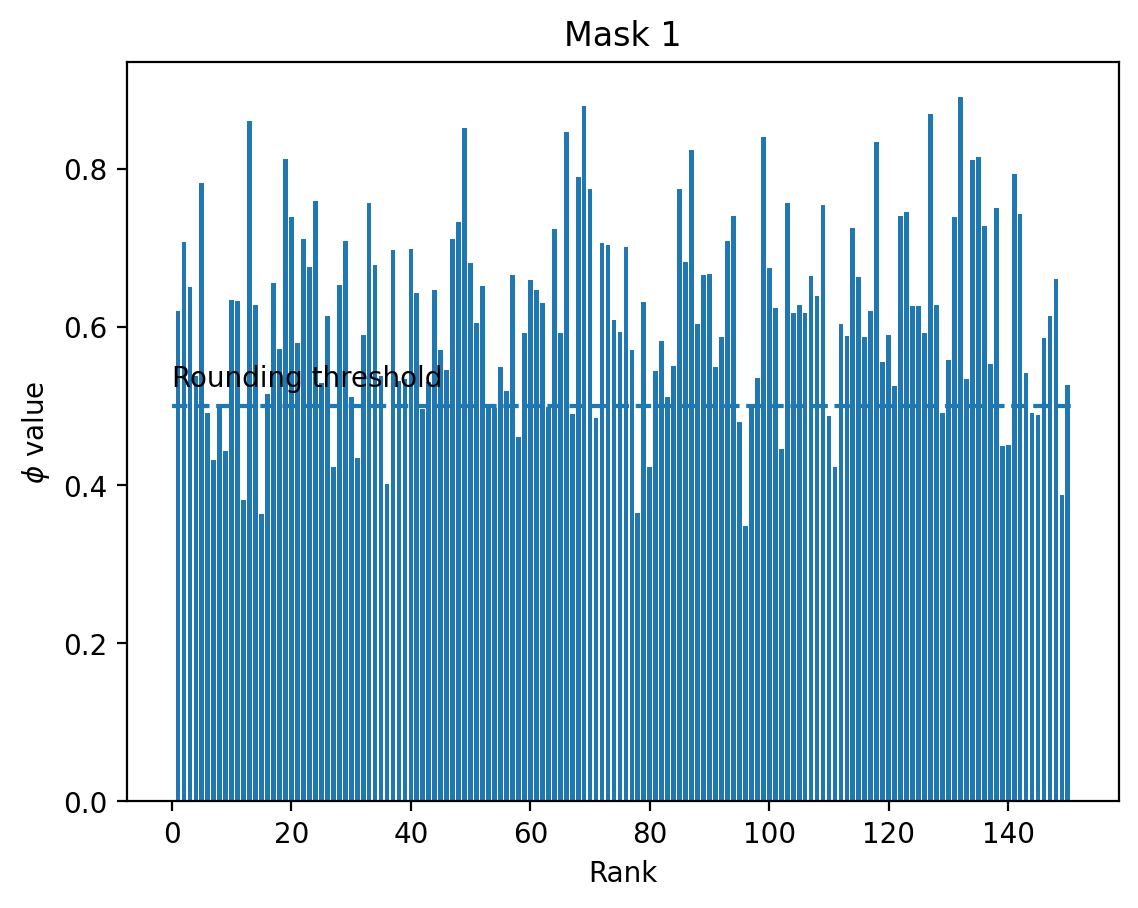

#nz ranks: 121/150

Compression:	2.560
Total compression:	1.434


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------




In [14]:
comps = []

for k, model in enumerate(models, 1):
    print(f"Model number {k}...")
    print()
    comps.append(get_comp_info(model))
    print()
    print()
    print(100*'-')
    print(100*'-')
    print(100*'-')
    print()
    print()

Let's plot the latent vector representations of a few batches of data.

In [15]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

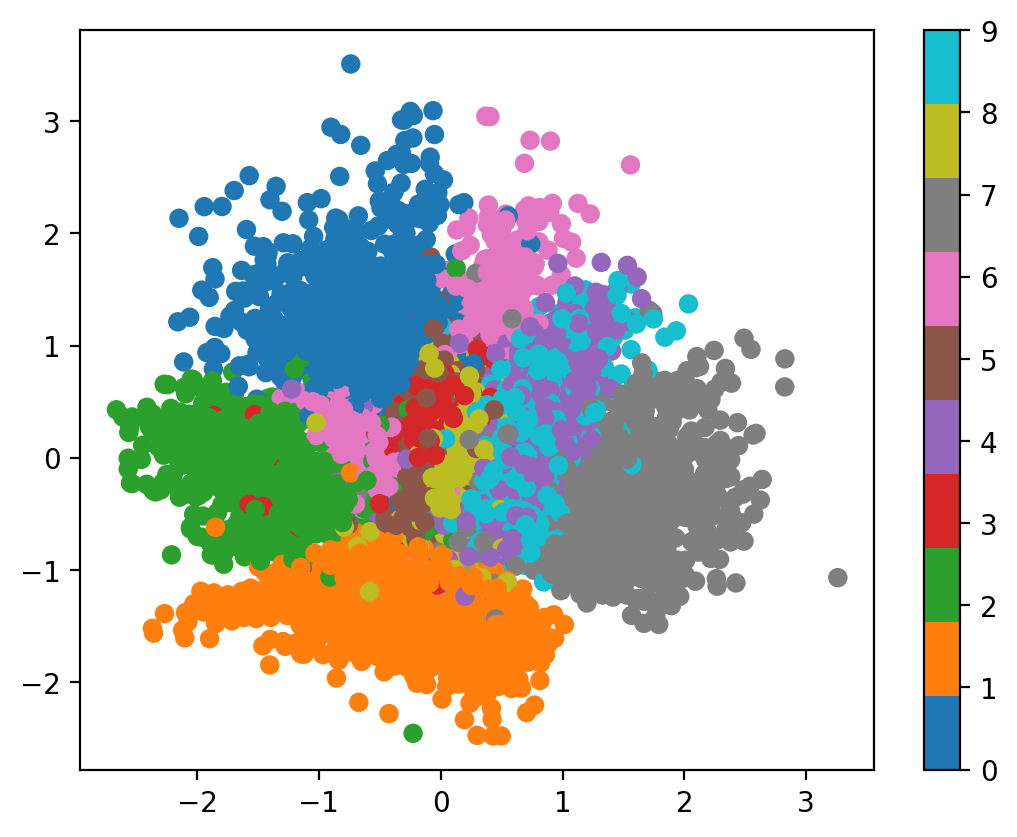

In [16]:
vae = models[0]

plot_latent(vae, data)

We can see that, compared to the traditional autoencoder, the range of values for latent vectors is much smaller, and more centralized. The distribution overall of $p(z \mid x)$ appears to be much closer to a Gaussian distribution.

Let's also look at the reconstructed digits from the latent space:

In [17]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

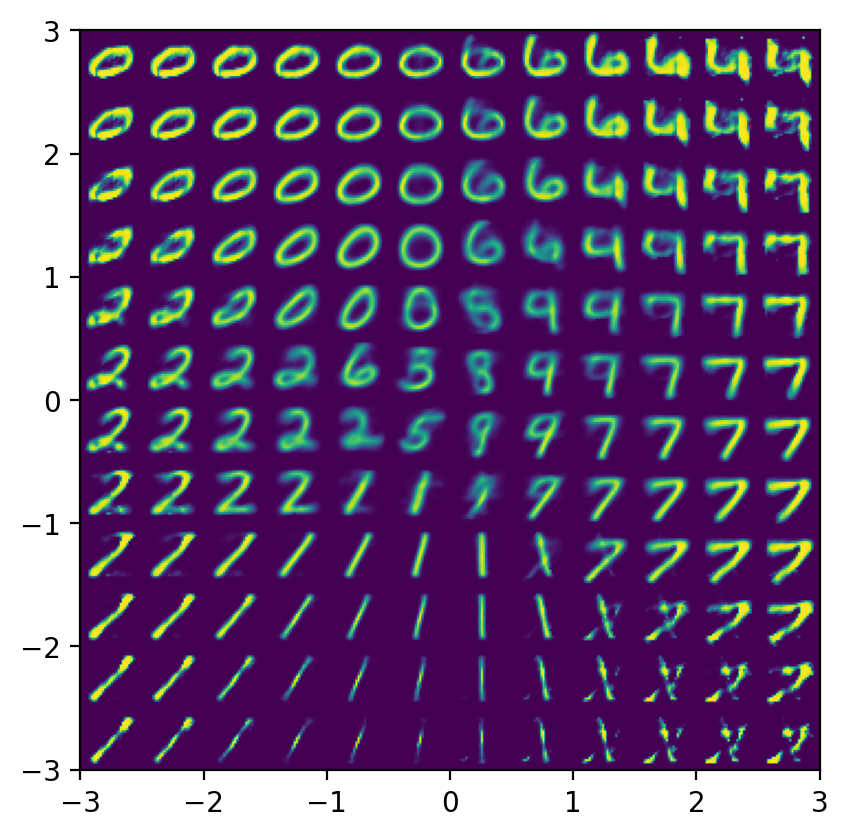

In [18]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))

In [19]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [20]:
x, y = next(iter(data)) # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

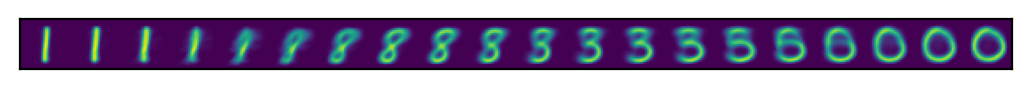

In [21]:
interpolate(vae, x_1, x_2, n=20)

In [22]:
from PIL import Image

def interpolate_gif(autoencoder, filename, x_1, x_2, n=100):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()*255
    
    images_list = [Image.fromarray(img.reshape(28, 28)).resize((256, 256)) for img in interpolate_list]
    images_list = images_list + images_list[::-1] # loop back beginning
    
    images_list[0].save(
        f'{filename}.gif', 
        save_all=True, 
        append_images=images_list[1:],
        loop=1)

In [23]:
interpolate_gif(vae, "mars-vae", x_1, x_2)

<img src='mars-vae.gif'>